# OCOM510M Data Science: Assessment 2

Student ID:

## 1. Aims, objectives and plan
Although we have already stated what is required, please formally state the aims and objectives of the project in your own words. 100-200 words.

Please demonstrate how you have conducted the project with a simple Gantt chart.

## 🧠 Problem Definition

An insurance company wants to leverage its historical claim data to predict whether a claim is fraudulent or genuine. The goal is to develop a predictive model that can **flag potential fraud cases for referral**, minimizing both:

- **False Positives** (referring genuine claims, which causes customer loss and stress)
- **False Negatives** (failing to detect fraudulent claims, which leads to financial loss)

A balanced and unbiased model is required, ideally achieving a **balanced error rate close to 5%**.

The business also seeks to quantify the **financial impact of model prediction errors**, particularly the cost associated with **losing customers (FP)** and **paying fraudulent claims (FN)**. This will be done using a pricing model based on average claim value, claim rate, and company overhead.

---

## 🔧 Techniques Used

### 1. Logistic Regression (Baseline Classification Model)

- A simple, interpretable, and widely-used model for binary classification.
- Outputs probability scores that allow threshold tuning for better trade-offs between false positives and false negatives.
- Used to establish a baseline for performance.
- Evaluation metrics include confusion matrix, precision, recall, F1-score, and ROC-AUC.

### 2. Random Forest Classifier (Ensemble Model)

- A powerful tree-based ensemble method that handles non-linear patterns and mixed data types well.
- Less prone to overfitting compared to individual decision trees.
- Can manage imbalanced datasets with built-in support for class weighting.
- Provides feature importance scores for interpretability.
- Performance is evaluated using the same metrics as Logistic Regression, with a focus on minimizing business impact through cost analysis of false positives and false negatives.



In [625]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from IPython.display import display
from functools import reduce
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder , StandardScaler , MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report , precision_recall_curve , accuracy_score , average_precision_score ,f1_score,roc_curve, roc_auc_score
from sklearn.model_selection import learning_curve , StratifiedKFold , cross_val_predict , GridSearchCV
from sklearn.ensemble import RandomForestClassifier




In [578]:
raw_tc_df = pd.read_csv('./TrainData/Train_Claim.csv')
raw_td_df = pd.read_csv('./TrainData/Train_Demographics.csv')
raw_tp_df = pd.read_csv('./TrainData/Train_Policy.csv')
raw_tv_df = pd.read_csv('./TrainData/Train_Vehicle.csv')
raw_t_df = pd.read_csv('./TrainData/Traindata_with_Target.csv')

display(raw_tc_df.head())
display(raw_td_df.head())
display(raw_tp_df.head())
display(raw_tv_df.head())
display(raw_t_df.head())


,CustomerID,DateOfIncident,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,IncidentState,IncidentCity,IncidentAddress,IncidentTime,NumberOfVehicles,PropertyDamage,BodilyInjuries,Witnesses,PoliceReport,AmountOfTotalClaim,AmountOfInjuryClaim,AmountOfPropertyClaim,AmountOfVehicleDamage
0,Cust10000,2015-02-03,Multi-vehicle Collision,Side Collision,Total Loss,Police,State7,City1,Location 1311,17,3,?,1,0,?,65501,13417,6071,46013
1,Cust10001,2015-02-02,Multi-vehicle Collision,Side Collision,Total Loss,Police,State7,City5,Location 1311,10,3,YES,2,1,YES,61382,15560,5919,39903
2,Cust10002,2015-01-15,Single Vehicle Collision,Side Collision,Minor Damage,Other,State8,City6,Location 2081,22,1,YES,2,3,NO,66755,11630,11630,43495
3,Cust10003,2015-01-19,Single Vehicle Collision,Side Collision,Minor Damage,Other,State9,City6,Location 2081,22,1,YES,2,3,NO,66243,12003,12003,42237
4,Cust10004,2015-01-09,Single Vehicle Collision,Rear Collision,Minor Damage,Fire,State8,City6,Location 1695,10,1,NO,2,1,YES,53544,8829,7234,37481


,CustomerID,InsuredAge,InsuredZipCode,InsuredGender,InsuredEducationLevel,InsuredOccupation,InsuredHobbies,CapitalGains,CapitalLoss,Country
0,Cust10000,35,454776,MALE,JD,armed-forces,movies,56700,-48500,India
1,Cust10001,36,454776,MALE,JD,tech-support,cross-fit,70600,-48500,India
2,Cust10002,33,603260,MALE,JD,armed-forces,polo,66400,-63700,India
3,Cust10003,36,474848,MALE,JD,armed-forces,polo,47900,-73400,India
4,Cust10004,29,457942,FEMALE,High School,exec-managerial,dancing,0,-41500,India


,InsurancePolicyNumber,CustomerLoyaltyPeriod,DateOfPolicyCoverage,InsurancePolicyState,Policy_CombinedSingleLimit,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,InsuredRelationship,CustomerID
0,110122,328,2014-10-17,State3,250/500,1000,1406.91,0,husband,Cust1001
1,110125,256,1990-05-25,State1,250/500,2000,1415.74,6000000,unmarried,Cust1004
2,110126,228,2014-06-06,State1,500/1000,1000,1583.91,6000000,unmarried,Cust1005
3,110127,256,2006-10-12,State3,250/500,1000,1351.10,0,unmarried,Cust1006
4,110128,137,2000-06-04,State2,250/500,1000,1333.35,0,husband,Cust1007


,CustomerID,VehicleAttribute,VehicleAttributeDetails
0,Cust20179,VehicleID,Vehicle8898
1,Cust21384,VehicleModel,Malibu
2,Cust33335,VehicleMake,Toyota
3,Cust27118,VehicleModel,Neon
4,Cust13038,VehicleID,Vehicle30212


,CustomerID,ReportedFraud
0,Cust20065,N
1,Cust37589,N
2,Cust24312,N
3,Cust5493,Y
4,Cust7704,Y


In [579]:
# Checkig if CustomerId is Repeating i.e value_count > 1
display('Train Claim' , raw_tc_df['CustomerID'].value_counts()[lambda x : x>1])
display('Train Demographics',raw_td_df['CustomerID'].value_counts()[lambda x : x >1])
display('Train Policy',raw_tp_df['CustomerID'].value_counts()[lambda x : x > 1])
display('Train Vehicle',raw_tv_df['CustomerID'].value_counts()[lambda x : x > 1])


'Train Claim'

Series([], Name: count, dtype: int64)

'Train Demographics'

Series([], Name: count, dtype: int64)

'Train Policy'

Series([], Name: count, dtype: int64)

'Train Vehicle'

CustomerID
Cust20179    4
Cust23045    4
Cust3818     4
Cust7461     4
Cust16944    4
            ..
Cust30090    4
Cust9783     4
Cust20478    4
Cust35879    4
Cust15237    4
Name: count, Length: 28836, dtype: int64

## Concluded from above
Only in `train_vehicle` table customerId are repeating 

In [580]:
# Pivot Train Vehicle Table 
pvt_tv_df = raw_tv_df.pivot_table(index='CustomerID',columns='VehicleAttribute',values='VehicleAttributeDetails',aggfunc='first').reset_index()

# Check null values
pvt_tv_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    28836 non-null  object
 1   VehicleID     28836 non-null  object
 2   VehicleMake   28836 non-null  object
 3   VehicleModel  28836 non-null  object
 4   VehicleYOM    28836 non-null  object
dtypes: object(5)
memory usage: 1.1+ MB


In [581]:
# Look Info

display(raw_tc_df.info())
display(raw_td_df.info())
display(raw_tp_df.info())
display(pvt_tv_df.info())
display(raw_t_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   CustomerID             28836 non-null  object
 1   DateOfIncident         28836 non-null  object
 2   TypeOfIncident         28836 non-null  object
 3   TypeOfCollission       28836 non-null  object
 4   SeverityOfIncident     28836 non-null  object
 5   AuthoritiesContacted   26144 non-null  object
 6   IncidentState          28836 non-null  object
 7   IncidentCity           28836 non-null  object
 8   IncidentAddress        28836 non-null  object
 9   IncidentTime           28836 non-null  int64 
 10  NumberOfVehicles       28836 non-null  int64 
 11  PropertyDamage         28836 non-null  object
 12  BodilyInjuries         28836 non-null  int64 
 13  Witnesses              28836 non-null  object
 14  PoliceReport           28836 non-null  object
 15  AmountOfTotalClaim 

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   CustomerID             28836 non-null  object
 1   InsuredAge             28836 non-null  int64 
 2   InsuredZipCode         28836 non-null  int64 
 3   InsuredGender          28806 non-null  object
 4   InsuredEducationLevel  28836 non-null  object
 5   InsuredOccupation      28836 non-null  object
 6   InsuredHobbies         28836 non-null  object
 7   CapitalGains           28836 non-null  int64 
 8   CapitalLoss            28836 non-null  int64 
 9   Country                28834 non-null  object
dtypes: int64(4), object(6)
memory usage: 2.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   InsurancePolicyNumber       28836 non-null  int64  
 1   CustomerLoyaltyPeriod       28836 non-null  int64  
 2   DateOfPolicyCoverage        28836 non-null  object 
 3   InsurancePolicyState        28836 non-null  object 
 4   Policy_CombinedSingleLimit  28836 non-null  object 
 5   Policy_Deductible           28836 non-null  int64  
 6   PolicyAnnualPremium         28836 non-null  float64
 7   UmbrellaLimit               28836 non-null  int64  
 8   InsuredRelationship         28836 non-null  object 
 9   CustomerID                  28836 non-null  object 
dtypes: float64(1), int64(4), object(5)
memory usage: 2.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    28836 non-null  object
 1   VehicleID     28836 non-null  object
 2   VehicleMake   28836 non-null  object
 3   VehicleModel  28836 non-null  object
 4   VehicleYOM    28836 non-null  object
dtypes: object(5)
memory usage: 1.1+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     28836 non-null  object
 1   ReportedFraud  28836 non-null  object
dtypes: object(2)
memory usage: 450.7+ KB


None

## Concluded from above
All Tables have `28836` records and `no null` values in `any` table

In [582]:
## Merge all 5 Tables on CustomerId
print('Train Claims Shape:' , raw_tc_df.shape)
print('Train Demographic Shape:' , raw_td_df.shape)
print('Train Policy Shape:' , raw_tp_df.shape)
print('Train Vehicle Shape:' , pvt_tv_df.shape)
print('Train Target Shape:' , raw_t_df.shape)

merged_df:DataFrame = reduce(lambda left,right : pd.merge(left,right,how='inner',on='CustomerID'), [raw_tc_df,raw_td_df,raw_tp_df,pvt_tv_df,raw_t_df])

print('Merged Table Shape:' , merged_df.shape)
print('Total Columns in Merged is equal to adition of all coulmns from individual tables ? ', (raw_tc_df.shape[1] +  raw_td_df.shape[1] + raw_tp_df.shape[1] +  pvt_tv_df.shape[1] + raw_t_df.shape[1] - 4 ) == merged_df.shape[1])

pd.set_option('display.max_columns', 100)
merged_df.head()

Train Claims Shape: (28836, 19)
Train Demographic Shape: (28836, 10)
Train Policy Shape: (28836, 10)
Train Vehicle Shape: (28836, 5)
Train Target Shape: (28836, 2)
Merged Table Shape: (28836, 42)
Total Columns in Merged is equal to adition of all coulmns from individual tables ?  True


,CustomerID,DateOfIncident,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,IncidentState,IncidentCity,IncidentAddress,IncidentTime,NumberOfVehicles,PropertyDamage,BodilyInjuries,Witnesses,PoliceReport,AmountOfTotalClaim,AmountOfInjuryClaim,AmountOfPropertyClaim,AmountOfVehicleDamage,InsuredAge,InsuredZipCode,InsuredGender,InsuredEducationLevel,InsuredOccupation,InsuredHobbies,CapitalGains,CapitalLoss,Country,InsurancePolicyNumber,CustomerLoyaltyPeriod,DateOfPolicyCoverage,InsurancePolicyState,Policy_CombinedSingleLimit,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,InsuredRelationship,VehicleID,VehicleMake,VehicleModel,VehicleYOM,ReportedFraud
0,Cust10000,2015-02-03,Multi-vehicle Collision,Side Collision,Total Loss,Police,State7,City1,Location 1311,17,3,?,1,0,?,65501,13417,6071,46013,35,454776,MALE,JD,armed-forces,movies,56700,-48500,India,119121,49,1998-10-25,State1,100/300,1000,1632.73,0,not-in-family,Vehicle26917,Audi,A5,2008,N
1,Cust10001,2015-02-02,Multi-vehicle Collision,Side Collision,Total Loss,Police,State7,City5,Location 1311,10,3,YES,2,1,YES,61382,15560,5919,39903,36,454776,MALE,JD,tech-support,cross-fit,70600,-48500,India,119122,114,2000-11-15,State1,100/300,1000,1255.19,0,not-in-family,Vehicle15893,Audi,A5,2006,N
2,Cust10002,2015-01-15,Single Vehicle Collision,Side Collision,Minor Damage,Other,State8,City6,Location 2081,22,1,YES,2,3,NO,66755,11630,11630,43495,33,603260,MALE,JD,armed-forces,polo,66400,-63700,India,119123,167,2001-02-12,State3,500/1000,617,1373.38,0,wife,Vehicle5152,Volkswagen,Jetta,1999,N
3,Cust10003,2015-01-19,Single Vehicle Collision,Side Collision,Minor Damage,Other,State9,City6,Location 2081,22,1,YES,2,3,NO,66243,12003,12003,42237,36,474848,MALE,JD,armed-forces,polo,47900,-73400,India,119124,190,2005-04-11,State2,500/1000,722,1337.60,0,own-child,Vehicle37363,Volkswagen,Jetta,2003,N
4,Cust10004,2015-01-09,Single Vehicle Collision,Rear Collision,Minor Damage,Fire,State8,City6,Location 1695,10,1,NO,2,1,YES,53544,8829,7234,37481,29,457942,FEMALE,High School,exec-managerial,dancing,0,-41500,India,119125,115,1996-10-25,State2,100/300,500,1353.73,4279863,unmarried,Vehicle28633,Toyota,CRV,2010,N


In [583]:
# Look for missing and duplicate
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CustomerID                  28836 non-null  object 
 1   DateOfIncident              28836 non-null  object 
 2   TypeOfIncident              28836 non-null  object 
 3   TypeOfCollission            28836 non-null  object 
 4   SeverityOfIncident          28836 non-null  object 
 5   AuthoritiesContacted        26144 non-null  object 
 6   IncidentState               28836 non-null  object 
 7   IncidentCity                28836 non-null  object 
 8   IncidentAddress             28836 non-null  object 
 9   IncidentTime                28836 non-null  int64  
 10  NumberOfVehicles            28836 non-null  int64  
 11  PropertyDamage              28836 non-null  object 
 12  BodilyInjuries              28836 non-null  int64  
 13  Witnesses                   288

In [584]:
print('Before Deduplicate' , merged_df.shape)
merged_df.drop_duplicates(inplace=True)
print('After Deduplicate' , merged_df.shape)

Before Deduplicate (28836, 42)
After Deduplicate (28836, 42)


## DataType Conversions 
 - DateOfIncident from Object  to Date Format
 - Witnesses from Object  to int64
 - AmountOfTotalClaim from Object  to float64
 - DateOfPolicyCoverage from Object  to Date Format
 - Policy_CombinedSingleLimit Split into 2 features
 - VehicleYOM from Object  to int64

/var/folders/2q/4h8qwwsx6t5446pyq1l03mjh0000gn/T/ipykernel_92294/1138944992.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([merged_df[col].dropna() for col in numeric_cols], labels=numeric_cols)


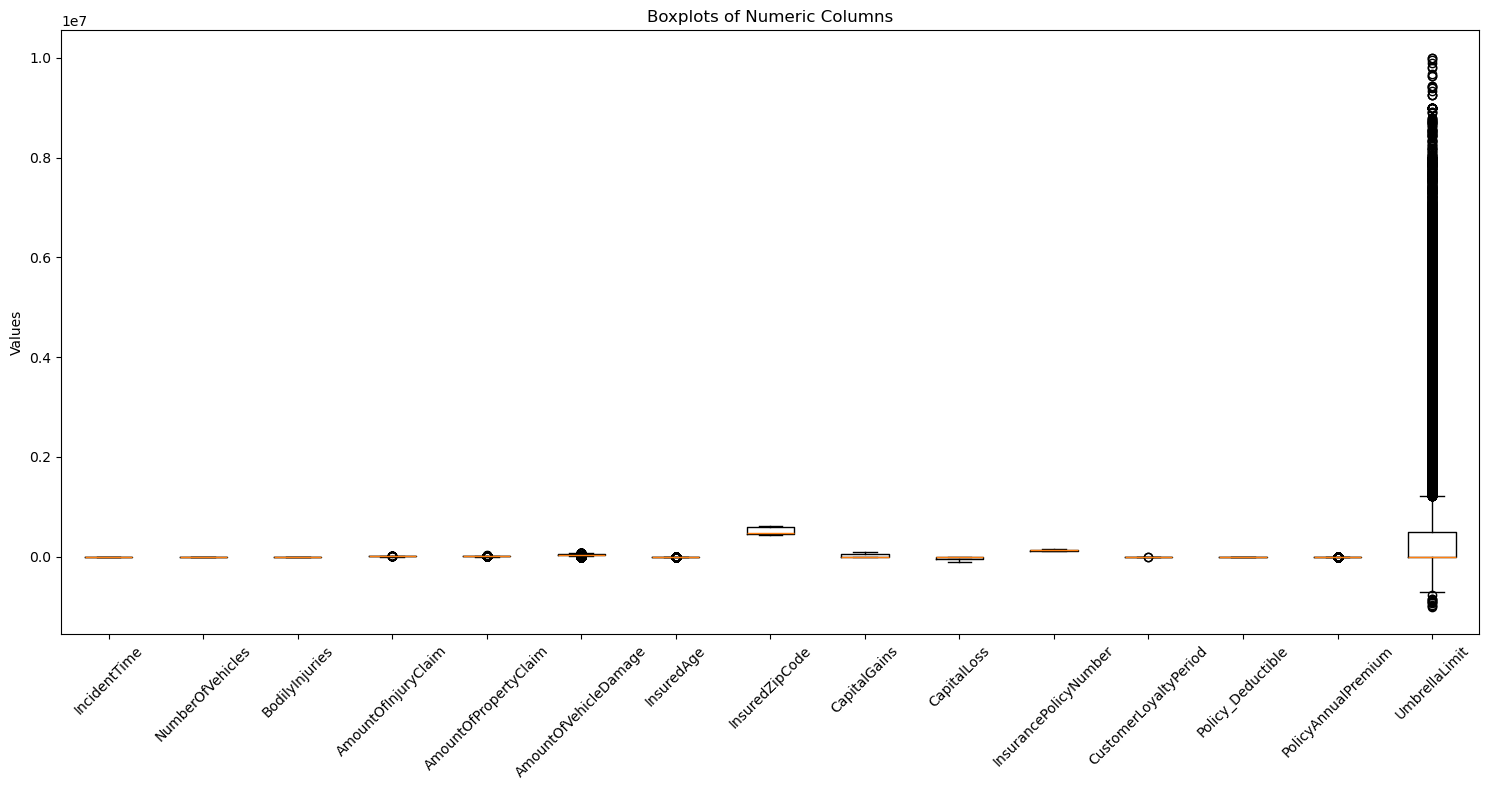

In [585]:
numeric_cols = merged_df.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(15, 8))
plt.boxplot([merged_df[col].dropna() for col in numeric_cols], labels=numeric_cols)
plt.xticks(rotation=45)
plt.title("Boxplots of Numeric Columns")
plt.ylabel("Values")
plt.tight_layout()
plt.show()

## 2. Understanding the case study

###  Case study analysis
State the key points that you found in the case and how you intend to deal with them appropriately to address the client's needs. (You can include more than four points.) 200-300 words.

1.
1. 
1. 
1. 



## 3. Pre-processing applied

**Create a new subheading for each stage that you do from the following items. Enter your code in the cells below the subheading.**

- Merging, pivoting and melting, if necessary
- Preparing the labels appropriately, if necessary
- Dealing with missing values (imputation, filtering) without leaking, if necessary
- Dealing with duplicate values, if necessary
- Scaling, without leaking, if necessary
- Dealing with correlation and collinearity, if necessary
- Variance analysis, if necessary
- Appropriate feature selection such as RFE, if necessary
- Appropriate feature extraction, if necessary
- Identifying and dealing with class imbalance, if necessary
- Identifying and dealing with outliers, if necessary
- Categorical and numerical encoding if necessary
- Other pre-processing 

### Merging, pivoting and melting, if necessary

### Preparing the labels appropriately, if necessary

In [586]:
print(merged_df['ReportedFraud'].value_counts(dropna=False))
print(merged_df['ReportedFraud'].value_counts(normalize=True))

ReportedFraud
N    21051
Y     7785
Name: count, dtype: int64
ReportedFraud
N    0.730025
Y    0.269975
Name: proportion, dtype: float64


#### Above results suggest Target label is `imbalanced` with `Y is ~26% and N is ~73%` and no missing value

In [587]:
# Encode the Labels into binary 
merged_df['ReportedFraud'].map({'N' : 0 , 'Y' : 1})
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CustomerID                  28836 non-null  object 
 1   DateOfIncident              28836 non-null  object 
 2   TypeOfIncident              28836 non-null  object 
 3   TypeOfCollission            28836 non-null  object 
 4   SeverityOfIncident          28836 non-null  object 
 5   AuthoritiesContacted        26144 non-null  object 
 6   IncidentState               28836 non-null  object 
 7   IncidentCity                28836 non-null  object 
 8   IncidentAddress             28836 non-null  object 
 9   IncidentTime                28836 non-null  int64  
 10  NumberOfVehicles            28836 non-null  int64  
 11  PropertyDamage              28836 non-null  object 
 12  BodilyInjuries              28836 non-null  int64  
 13  Witnesses                   288

### Dealing with datatype conversions
 - DateOfIncident from Object  to Date Format
 - Witnesses from Object  to int64
 - AmountOfTotalClaim from Object  to float64
 - DateOfPolicyCoverage from Object  to Date Format
 - Policy_CombinedSingleLimit Split into 2 features
 - VehicleYOM from Object  to int64

In [588]:
class ColumnTypeConverter:
    def __init__(self, column_name, target_type='datetime', errors='coerce'):
        self.column_name = column_name
        self.target_type = target_type
        self.errors = errors

    def transform(self, df):
        if self.column_name not in df.columns:
            raise ValueError(f"Column '{self.column_name}' not found in DataFrame.")
        
        original_non_nulls = df[self.column_name].notna().sum()

        if self.target_type == 'datetime':
            df[self.column_name] = pd.to_datetime(df[self.column_name], errors=self.errors)
        elif self.target_type == 'int64':
            df[self.column_name] = pd.to_numeric(df[self.column_name], errors=self.errors).astype('Int64')
        elif self.target_type == 'float64':
            df[self.column_name] = pd.to_numeric(df[self.column_name], errors=self.errors).astype('float64')
        else:
            raise ValueError("target_type must be one of: 'datetime', 'int64', 'float64'")

        converted_non_nulls = df[self.column_name].notna().sum()
        failed_conversions = original_non_nulls - converted_non_nulls

        print(f"[{self.column_name}] Conversion Summary to '{self.target_type}':")
        print(f"✅ Successfully converted: {converted_non_nulls}")
        print(f"❌ Failed conversions (NaT or NaN): {failed_conversions}")
        
        return df


In [589]:
dateOfIncident = ColumnTypeConverter('DateOfIncident',target_type='datetime',errors='coerce')
dateOfPolicyCoverage = ColumnTypeConverter('DateOfPolicyCoverage',target_type='datetime',errors='coerce')
witnesses = ColumnTypeConverter('Witnesses',target_type='float64',errors='coerce')
vehicleYom = ColumnTypeConverter('VehicleYOM',target_type='int64',errors='coerce')
amountOfTotalClaim = ColumnTypeConverter('AmountOfTotalClaim',target_type='float64',errors='coerce')

dateOfIncident.transform(merged_df)
dateOfPolicyCoverage.transform(merged_df)
witnesses.transform(merged_df)
vehicleYom.transform(merged_df)
amountOfTotalClaim.transform(merged_df)
merged_df.info()

[DateOfIncident] Conversion Summary to 'datetime':
✅ Successfully converted: 28836
❌ Failed conversions (NaT or NaN): 0
[DateOfPolicyCoverage] Conversion Summary to 'datetime':
✅ Successfully converted: 28836
❌ Failed conversions (NaT or NaN): 0
[Witnesses] Conversion Summary to 'float64':
✅ Successfully converted: 28790
❌ Failed conversions (NaT or NaN): 46
[VehicleYOM] Conversion Summary to 'int64':
✅ Successfully converted: 28836
❌ Failed conversions (NaT or NaN): 0
[AmountOfTotalClaim] Conversion Summary to 'float64':
✅ Successfully converted: 28786
❌ Failed conversions (NaT or NaN): 50
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   CustomerID                  28836 non-null  object        
 1   DateOfIncident              28836 non-null  datetime64[ns]
 2   TypeOfIncident              2883

##### ✅ Successful Conversions

- **DateOfIncident** and **DateOfPolicyCoverage**:  
  Fully converted to `datetime64[ns]`.

- **VehicleYOM**:  
  All values successfully converted to `Int64`.

- **Witnesses**:  
  Mostly successful; **46 missing** (`NaT` or `NaN`).

- **AmountOfTotalClaim**:  
  **50 values could not be converted** to `float64`.


#### 🕒 Date Feature Engineering

To enhance model performance and extract meaningful temporal patterns from the `DateOfIncident` and `DateOfPolicyCoverage` columns, the following date-based features were engineered:

#### ✅ Extracted from `DateOfIncident`
| Feature Name            | Description                                   |
|-------------------------|-----------------------------------------------|
| `IncidentYear`          | Year in which the incident occurred           |
| `IncidentMonth`         | Month (1–12) of the incident                  |
| `IncidentDay`           | Day of the month when the incident occurred   |
| `IncidentWeekDay`       | Day of the week (0=Monday, 6=Sunday)          |
| `IncidentWeek`          | ISO calendar week number                      |
| `IncidentIsOnWeekend`   | Binary flag indicating if the incident happened on a weekend (`1` = Saturday/Sunday) |

#### 🔁 Derived from `DateOfIncident` and `DateOfPolicyCoverage`
| Feature Name             | Description                                        |
|--------------------------|----------------------------------------------------|
| `DaysSincePolicyStart`   | Number of days between policy coverage start date and the date of incident. Reflects policy age at time of incident. |


#### 🗑️ Dropping Raw Date Columns

After extracting meaningful features from the datetime columns `DateOfIncident` and `DateOfPolicyCoverage`, the original columns were no longer needed.

#### ❌ Dropped Columns
| Column                 | Reason for Removal                                      |
|------------------------|---------------------------------------------------------|
| `DateOfIncident`       | Replaced by derived features like `IncidentMonth`, `IncidentWeekday`, and `DaysSincePolicyStart` |
| `DateOfPolicyCoverage` | Used only to compute `DaysSincePolicyStart`            |



In [590]:
merged_df['IncidentYear'] = merged_df['DateOfIncident'].dt.year
merged_df['IncidentMonth'] = merged_df['DateOfIncident'].dt.month
merged_df['IncidentDay'] = merged_df['DateOfIncident'].dt.day
merged_df['IncidentWeekDay'] = merged_df['DateOfIncident'].dt.weekday
merged_df['IncidentWeek'] = merged_df['DateOfIncident'].dt.isocalendar().week
merged_df['IncidentIsOnWeekend'] = merged_df['IncidentWeekDay'].isin([5,6]).astype(int)
merged_df['DaysSincePolicyStart'] = (merged_df['DateOfIncident'] - merged_df['DateOfPolicyCoverage']).dt.days

merged_df.drop(columns=['DateOfIncident','DateOfPolicyCoverage'],inplace=True)

In [591]:
merged_df.head()

,CustomerID,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,IncidentState,IncidentCity,IncidentAddress,IncidentTime,NumberOfVehicles,PropertyDamage,BodilyInjuries,Witnesses,PoliceReport,AmountOfTotalClaim,AmountOfInjuryClaim,AmountOfPropertyClaim,AmountOfVehicleDamage,InsuredAge,InsuredZipCode,InsuredGender,InsuredEducationLevel,InsuredOccupation,InsuredHobbies,CapitalGains,CapitalLoss,Country,InsurancePolicyNumber,CustomerLoyaltyPeriod,InsurancePolicyState,Policy_CombinedSingleLimit,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,InsuredRelationship,VehicleID,VehicleMake,VehicleModel,VehicleYOM,ReportedFraud,IncidentYear,IncidentMonth,IncidentDay,IncidentWeekDay,IncidentWeek,IncidentIsOnWeekend,DaysSincePolicyStart
0,Cust10000,Multi-vehicle Collision,Side Collision,Total Loss,Police,State7,City1,Location 1311,17,3,?,1,0.0,?,65501.0,13417,6071,46013,35,454776,MALE,JD,armed-forces,movies,56700,-48500,India,119121,49,State1,100/300,1000,1632.73,0,not-in-family,Vehicle26917,Audi,A5,2008,N,2015,2,3,1,6,0,5945
1,Cust10001,Multi-vehicle Collision,Side Collision,Total Loss,Police,State7,City5,Location 1311,10,3,YES,2,1.0,YES,61382.0,15560,5919,39903,36,454776,MALE,JD,tech-support,cross-fit,70600,-48500,India,119122,114,State1,100/300,1000,1255.19,0,not-in-family,Vehicle15893,Audi,A5,2006,N,2015,2,2,0,6,0,5192
2,Cust10002,Single Vehicle Collision,Side Collision,Minor Damage,Other,State8,City6,Location 2081,22,1,YES,2,3.0,NO,66755.0,11630,11630,43495,33,603260,MALE,JD,armed-forces,polo,66400,-63700,India,119123,167,State3,500/1000,617,1373.38,0,wife,Vehicle5152,Volkswagen,Jetta,1999,N,2015,1,15,3,3,0,5085
3,Cust10003,Single Vehicle Collision,Side Collision,Minor Damage,Other,State9,City6,Location 2081,22,1,YES,2,3.0,NO,66243.0,12003,12003,42237,36,474848,MALE,JD,armed-forces,polo,47900,-73400,India,119124,190,State2,500/1000,722,1337.60,0,own-child,Vehicle37363,Volkswagen,Jetta,2003,N,2015,1,19,0,4,0,3570
4,Cust10004,Single Vehicle Collision,Rear Collision,Minor Damage,Fire,State8,City6,Location 1695,10,1,NO,2,1.0,YES,53544.0,8829,7234,37481,29,457942,FEMALE,High School,exec-managerial,dancing,0,-41500,India,119125,115,State2,100/300,500,1353.73,4279863,unmarried,Vehicle28633,Toyota,CRV,2010,N,2015,1,9,4,2,0,6650


##### ✅ Derived Features from `Policy_CombinedSingleLimit`

The original column was split into two new float columns:

| Column            | Non-Null Count | Dtype    | Description                         |
|------------------|----------------|----------|-------------------------------------|
| `LimitPerPerson` | 28836          | float64  | Insurance limit per person          |
| `LimitPerAccident` | 28836        | float64  | Insurance limit per accident        |

- All values successfully converted to `float64`
- No missing values detected
- Original column `Policy_CombinedSingleLimit` was dropped after transformation


In [592]:
# Split Policy_CombinedSingleLimit into 2 columns 
merged_df[['LimitPerPerson', 'LimitPerAccident']] = merged_df['Policy_CombinedSingleLimit'].str.split('/', expand=True).astype(float)
merged_df[['LimitPerPerson', 'LimitPerAccident']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   LimitPerPerson    28836 non-null  float64
 1   LimitPerAccident  28836 non-null  float64
dtypes: float64(2)
memory usage: 450.7 KB


#### 🧹 Missing Value Handling Strategy

Based on the attribute documentation for the `CSE9099c` dataset, multiple missing value indicators are used across different columns. Below is a detailed plan to clean and standardize missing values **before modeling**.

---

##### 🔍 Step 1: Replace Custom Missing Indicators

##### 🟨 Demographics
| Column                 | Missing Indicator | Suggested Replacement      |
|------------------------|-------------------|----------------------------|
| `InsuredGender`        | "NA"              | Replace with `'Unknown'`   |
| `Country`              | NaN (2 missing)   | Replace with `'Unknown'`   |

##### 🟦 Policy Information
| Column                | Missing Indicator | Suggested Replacement      |
|-----------------------|-------------------|----------------------------|
| `PolicyAnnualPremium` | `-1`              | Replace with `np.nan`      |
| `TotalCharges`        | `"MISSINGVAL"`    | Replace with `np.nan`      |
| `ContractType`        | `"NA"`            | Replace with `'Unknown'`   |

##### 🟥 Claim Information
| Column                 | Missing Indicator   | Suggested Replacement      |
|----------------------- |---------------------|----------------------------|
| `TypeOfCollission`     | `"?"`               | Replace with `'Unknown'`   |
| `PropertyDamage`       | `"?"`               | Replace with `'Unknown'`   |
| `PoliceReport`         | `"?"`               | Replace with `'Unknown'`   |
| `IncidentTime`         | `-5`                | Replace with `np.nan`      |
| `Witnesses`            | `"MISSINGVALUE"`    | Replace with `np.nan`      |
| `AmountOfTotalClaim`   | `"MISSEDDATA"`      | Replace with `np.nan`      |
| `AuthoritiesContacted`  | `Nan`              | Replace with `Unknown`      |

##### 🟪 Vehicle Data
| Column                    | Missing Indicator | Suggested Replacement      |
|---------------------------|-------------------|----------------------------|
| `VehicleAttributeDetails` | `"???"`           | Replace with `'Unknown'`   |
| `Vehiclemake`             | `"???"`           | Replace with `'Unknown'`   |

---




In [593]:

merged_df.replace({
    'InsuredGender': {'NA': 'Unknown'},
    'ContractType': {'NA': 'Unknown'},
    'TypeOfCollission': {'?': 'Unknown'},
    'PropertyDamage': {'?': 'Unknown'},
    'PoliceReport': {'?': 'Unknown'},
    'TotalCharges': {'MISSINGVAL': np.nan},
    'AmountOfTotalClaim': {'MISSEDDATA': np.nan},
    'Witnesses': {'MISSINGVALUE': np.nan},
    'VehicleAttributeDetails': {'???': 'Unknown'},
    'VehicleMake':{'???': 'Unknown'}
}, inplace=True)

# Replace numeric placeholder values
merged_df['IncidentTime'] = merged_df['IncidentTime'].replace(-5, np.nan)
merged_df['PolicyAnnualPremium'] = merged_df['PolicyAnnualPremium'].replace(-1, np.nan)

merged_df['AuthoritiesContacted'] = merged_df['AuthoritiesContacted'].fillna('Unknown')

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CustomerID                  28836 non-null  object 
 1   TypeOfIncident              28836 non-null  object 
 2   TypeOfCollission            28836 non-null  object 
 3   SeverityOfIncident          28836 non-null  object 
 4   AuthoritiesContacted        28836 non-null  object 
 5   IncidentState               28836 non-null  object 
 6   IncidentCity                28836 non-null  object 
 7   IncidentAddress             28836 non-null  object 
 8   IncidentTime                28805 non-null  float64
 9   NumberOfVehicles            28836 non-null  int64  
 10  PropertyDamage              28836 non-null  object 
 11  BodilyInjuries              28836 non-null  int64  
 12  Witnesses                   28790 non-null  float64
 13  PoliceReport                288

#### 🔍 Unique Value Count Analysis

To understand the structure and distribution of values across columns, we calculated the number of unique values in each column using the following code:

#### 🎯 Why This Matters
Analyzing unique value counts helps in:

- **Identifying High-Cardinality Features**
Columns like CustomerID, VehicleID, or IncidentAddress may have thousands of unique values, which are not ideal for one-hot encoding and can increase dimensionality unnecessarily.

- **Spotting Low-Cardinality Categorical Features**
Features with only a few unique values (e.g., Gender, PropertyDamage, PoliceReport) are perfect candidates for one-hot encoding.

- **Detecting Constant or Near-Constant Columns**
Columns with only one unique value offer no variability and can be safely dropped.

In [594]:
# Only do it for dtype =object
unique_counts_df = pd.DataFrame({
    'Column': merged_df.select_dtypes(include='object').columns,
    'UniqueValues': [merged_df[col].nunique(dropna=False) for col in merged_df.select_dtypes(include='object').columns]
}).sort_values(by='UniqueValues', ascending=False)

# Only do it for dtype  not object i.e numeric
unique_numeric_counts_df = pd.DataFrame({
    'Column': merged_df.select_dtypes(exclude='object').columns,
    'UniqueValues': [merged_df[col].nunique(dropna=False) for col in merged_df.select_dtypes(exclude='object').columns]
}).sort_values(by='UniqueValues', ascending=False)

print('Object type' , unique_counts_df)
print('Non Object type' , unique_numeric_counts_df)

Object type                         Column  UniqueValues
0                   CustomerID         28836
18                   VehicleID         28836
7              IncidentAddress          1000
20                VehicleModel            39
13              InsuredHobbies            20
19                 VehicleMake            15
12           InsuredOccupation            14
16  Policy_CombinedSingleLimit             9
11       InsuredEducationLevel             7
6                 IncidentCity             7
5                IncidentState             7
17         InsuredRelationship             6
4         AuthoritiesContacted             5
1               TypeOfIncident             4
3           SeverityOfIncident             4
2             TypeOfCollission             4
9                 PoliceReport             3
10               InsuredGender             3
8               PropertyDamage             3
15        InsurancePolicyState             3
14                     Country             

#### 📊 Unique Value Count Summary

The number of unique values was calculated for each column to guide **feature engineering, encoding decisions, and dimensionality reduction**.

---
| Column                  | Notes (based on earlier unique value counts)                         |
| ----------------------- | -------------------------------------------------------------------- |
| `TypeOfIncident`        | 4 values – ✅ encode                                                  |
| `TypeOfCollission`      | 4 values – ✅ encode                                                  |
| `SeverityOfIncident`    | 4 values – ✅ encode                                                  |
| `AuthoritiesContacted`  | 5 values – ✅ encode                                                  |
| `PropertyDamage`        | 3 values – ✅ encode                                                  |
| `PoliceReport`          | 3 values – ✅ encode                                                  |
| `InsuredGender`         | 3 values – ✅ encode                                                  |
| `InsuredEducationLevel` | 7 values – ✅ encode                                                  |
| `InsuredOccupation`     | 14 values – ✅ encode                                                 |
| `InsuredHobbies`        | 20 values – ✅ encode                                                 |                                                 
| `InsurancePolicyState`  | 3 values – ✅ encode                                                  |
| `InsuredRelationship`   | 6 values – ✅ encode                                                  |
| `VehicleMake`           | 15 values – ⚠️ encode or group (depends on model)                    |
| `VehicleModel`          | 39 values – ⚠️ maybe encode top N, group rest  -- but will leave it for timebeing                      |
| `ReportedFraud`         | 🎯 This is the target — do **not encode**, just map `{‘Y’:1, ‘N’:0}` |


---

### ❌ Constant Features (to be dropped)

| Column           | Unique Values |
|------------------|----------------|
| `IncidentYear`   | 1              |
| `Country`        | 2 ( 2 Unnkown and rest India')              |


### ❌ Hight Cardinality Features (to be dropped)
| Column            | Reason                                                  |
| ----------------- | ------------------------------------------------------- |
| `IncidentAddress` | 1000 unique values — likely not useful for encoding    |
| `CustomerID`  |  High cardinality (28836 values) — drop or treat specially |
| `VehicleID`  | High cardinality (28836 values) — drop or treat specially |



This unique value audit helps decide:
- What to drop
- What to one-hot encode
- What to normalize or transform


In [595]:
## Print Vehicke Make and Model to decide how to group them if needed to be grouped
print(merged_df['VehicleMake'].value_counts())
print(merged_df['VehicleModel'].value_counts())
print(merged_df['InsuredHobbies'].value_counts())

VehicleMake
Saab          2415
Suburu        2313
Nissan        2300
Dodge         2263
Chevrolet     2174
Ford          2158
Accura        2099
BMW           2073
Toyota        1981
Volkswagen    1960
Audi          1952
Jeep          1946
Mercedes      1659
Honda         1493
Unknown         50
Name: count, dtype: int64
VehicleModel
RAM               1344
Wrangler          1261
A3                1102
MDX               1054
Jetta             1037
Neon               928
Pathfinder         919
Passat             888
Legacy             887
92x                859
Malibu             828
95                 820
A5                 812
F150               797
Forrestor          784
Camry              771
Tahoe              736
93                 724
Maxima             722
Grand Cherokee     718
Escape             706
Ultima             698
E400               695
X5                 691
TL                 684
Silverado          668
Fusion             650
Highlander         633
Civic              6

#### Conluded from above will leave grouping VehicalMake and Model as I cant see any natural grouping -- may need to revisit if model struggling from overfitting

#### 🗑️ **Dropped** Irrelevant or High-Cardinality Columns

To reduce noise and avoid overfitting, the following columns were removed:

| Column                    | Reason for Removal                             |
|---------------------------|------------------------------------------------|
| `Policy_CombinedSingleLimit` | Replaced by `LimitPerPerson` and `LimitPerAccident` |
| `CustomerID`             | Unique identifier, not useful for modeling     |
| `InsurancePolicyNumber`  | High-cardinality identifier, non-informative   |
| `VehicleID`              | Unique identifier, adds no predictive value    |
| `IncidentAddress`        | High-cardinality |
| `IncidentYear`           | 1 value |
| `Country`                | 1 value |

In [596]:
merged_df.drop(['Policy_CombinedSingleLimit','CustomerID','InsurancePolicyNumber','VehicleID','IncidentAddress','IncidentYear','Country'] , axis=1,inplace=True)
merged_df.columns
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28836 entries, 0 to 28835
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   TypeOfIncident         28836 non-null  object 
 1   TypeOfCollission       28836 non-null  object 
 2   SeverityOfIncident     28836 non-null  object 
 3   AuthoritiesContacted   28836 non-null  object 
 4   IncidentState          28836 non-null  object 
 5   IncidentCity           28836 non-null  object 
 6   IncidentTime           28805 non-null  float64
 7   NumberOfVehicles       28836 non-null  int64  
 8   PropertyDamage         28836 non-null  object 
 9   BodilyInjuries         28836 non-null  int64  
 10  Witnesses              28790 non-null  float64
 11  PoliceReport           28836 non-null  object 
 12  AmountOfTotalClaim     28786 non-null  float64
 13  AmountOfInjuryClaim    28836 non-null  int64  
 14  AmountOfPropertyClaim  28836 non-null  int64  
 15  Am

### Check if there is a class-imbalance problem by conducting basic statistics and/or clustering on the dataset and propose a solution.

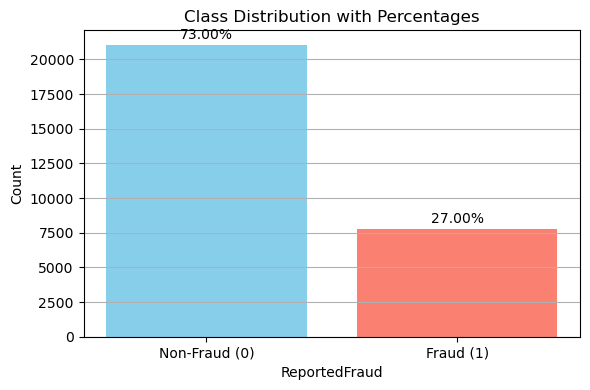

In [597]:

# Class distribution (already mapped to 0/1)
class_counts = merged_df['ReportedFraud'].value_counts()
class_percentages = class_counts / class_counts.sum() * 100

# Bar plot
plt.figure(figsize=(6, 4))
bars = plt.bar(class_counts.index.astype(str), class_counts.values, color=['skyblue', 'salmon'])

# Add percentage labels on top of each bar
for bar, percentage in zip(bars, class_percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 200, f'{percentage:.2f}%', ha='center', va='bottom')

# Labels and styling
plt.title("Class Distribution with Percentages")
plt.xlabel("ReportedFraud")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["Non-Fraud (0)", "Fraud (1)"])
plt.grid(axis='y')
plt.tight_layout()
plt.show()


#### 📊 Class Imbalance Analysis

#### 🖼️ Visualization Summary

The bar plot below illustrates the distribution of the target variable `ReportedFraud`:

- **Non-Fraud (0):** 73%
- **Fraud (1):** 27%

Although the classes are not extremely imbalanced (e.g., 95/5), there is still a **moderate imbalance** between fraudulent and non-fraudulent claims.

---

#### 🔍 Interpretation

- The dataset shows **27% fraudulent** and **73% non-fraudulent** claims.
- This imbalance could lead to:
  - A model that is biased toward predicting the majority class (non-fraud)
  - High overall accuracy but **low recall** or **low F1-score** for the fraud class
- Relying solely on accuracy would be misleading in this context.

---

#### 💡 Recommended Solutions

| Strategy                        | Description                                                                 |
|---------------------------------|-----------------------------------------------------------------------------|
| `class_weight='balanced'`       | Automatically adjusts the model’s loss to give more importance to the minority class |
| **Stratified Cross-Validation** | Ensures each fold maintains the original class distribution during model evaluation |
| **Precision-Recall Evaluation** | Use metrics like precision, recall, F1-score, and AUC-PR for fair evaluation |


These strategies help in building a model that treats fraud detection with proper attention, even with imbalanced data.


###  Rescale the attributes if necessary
#### Plot Numeric Feature Distributions (Histograms) to infer Scalaing Strategy

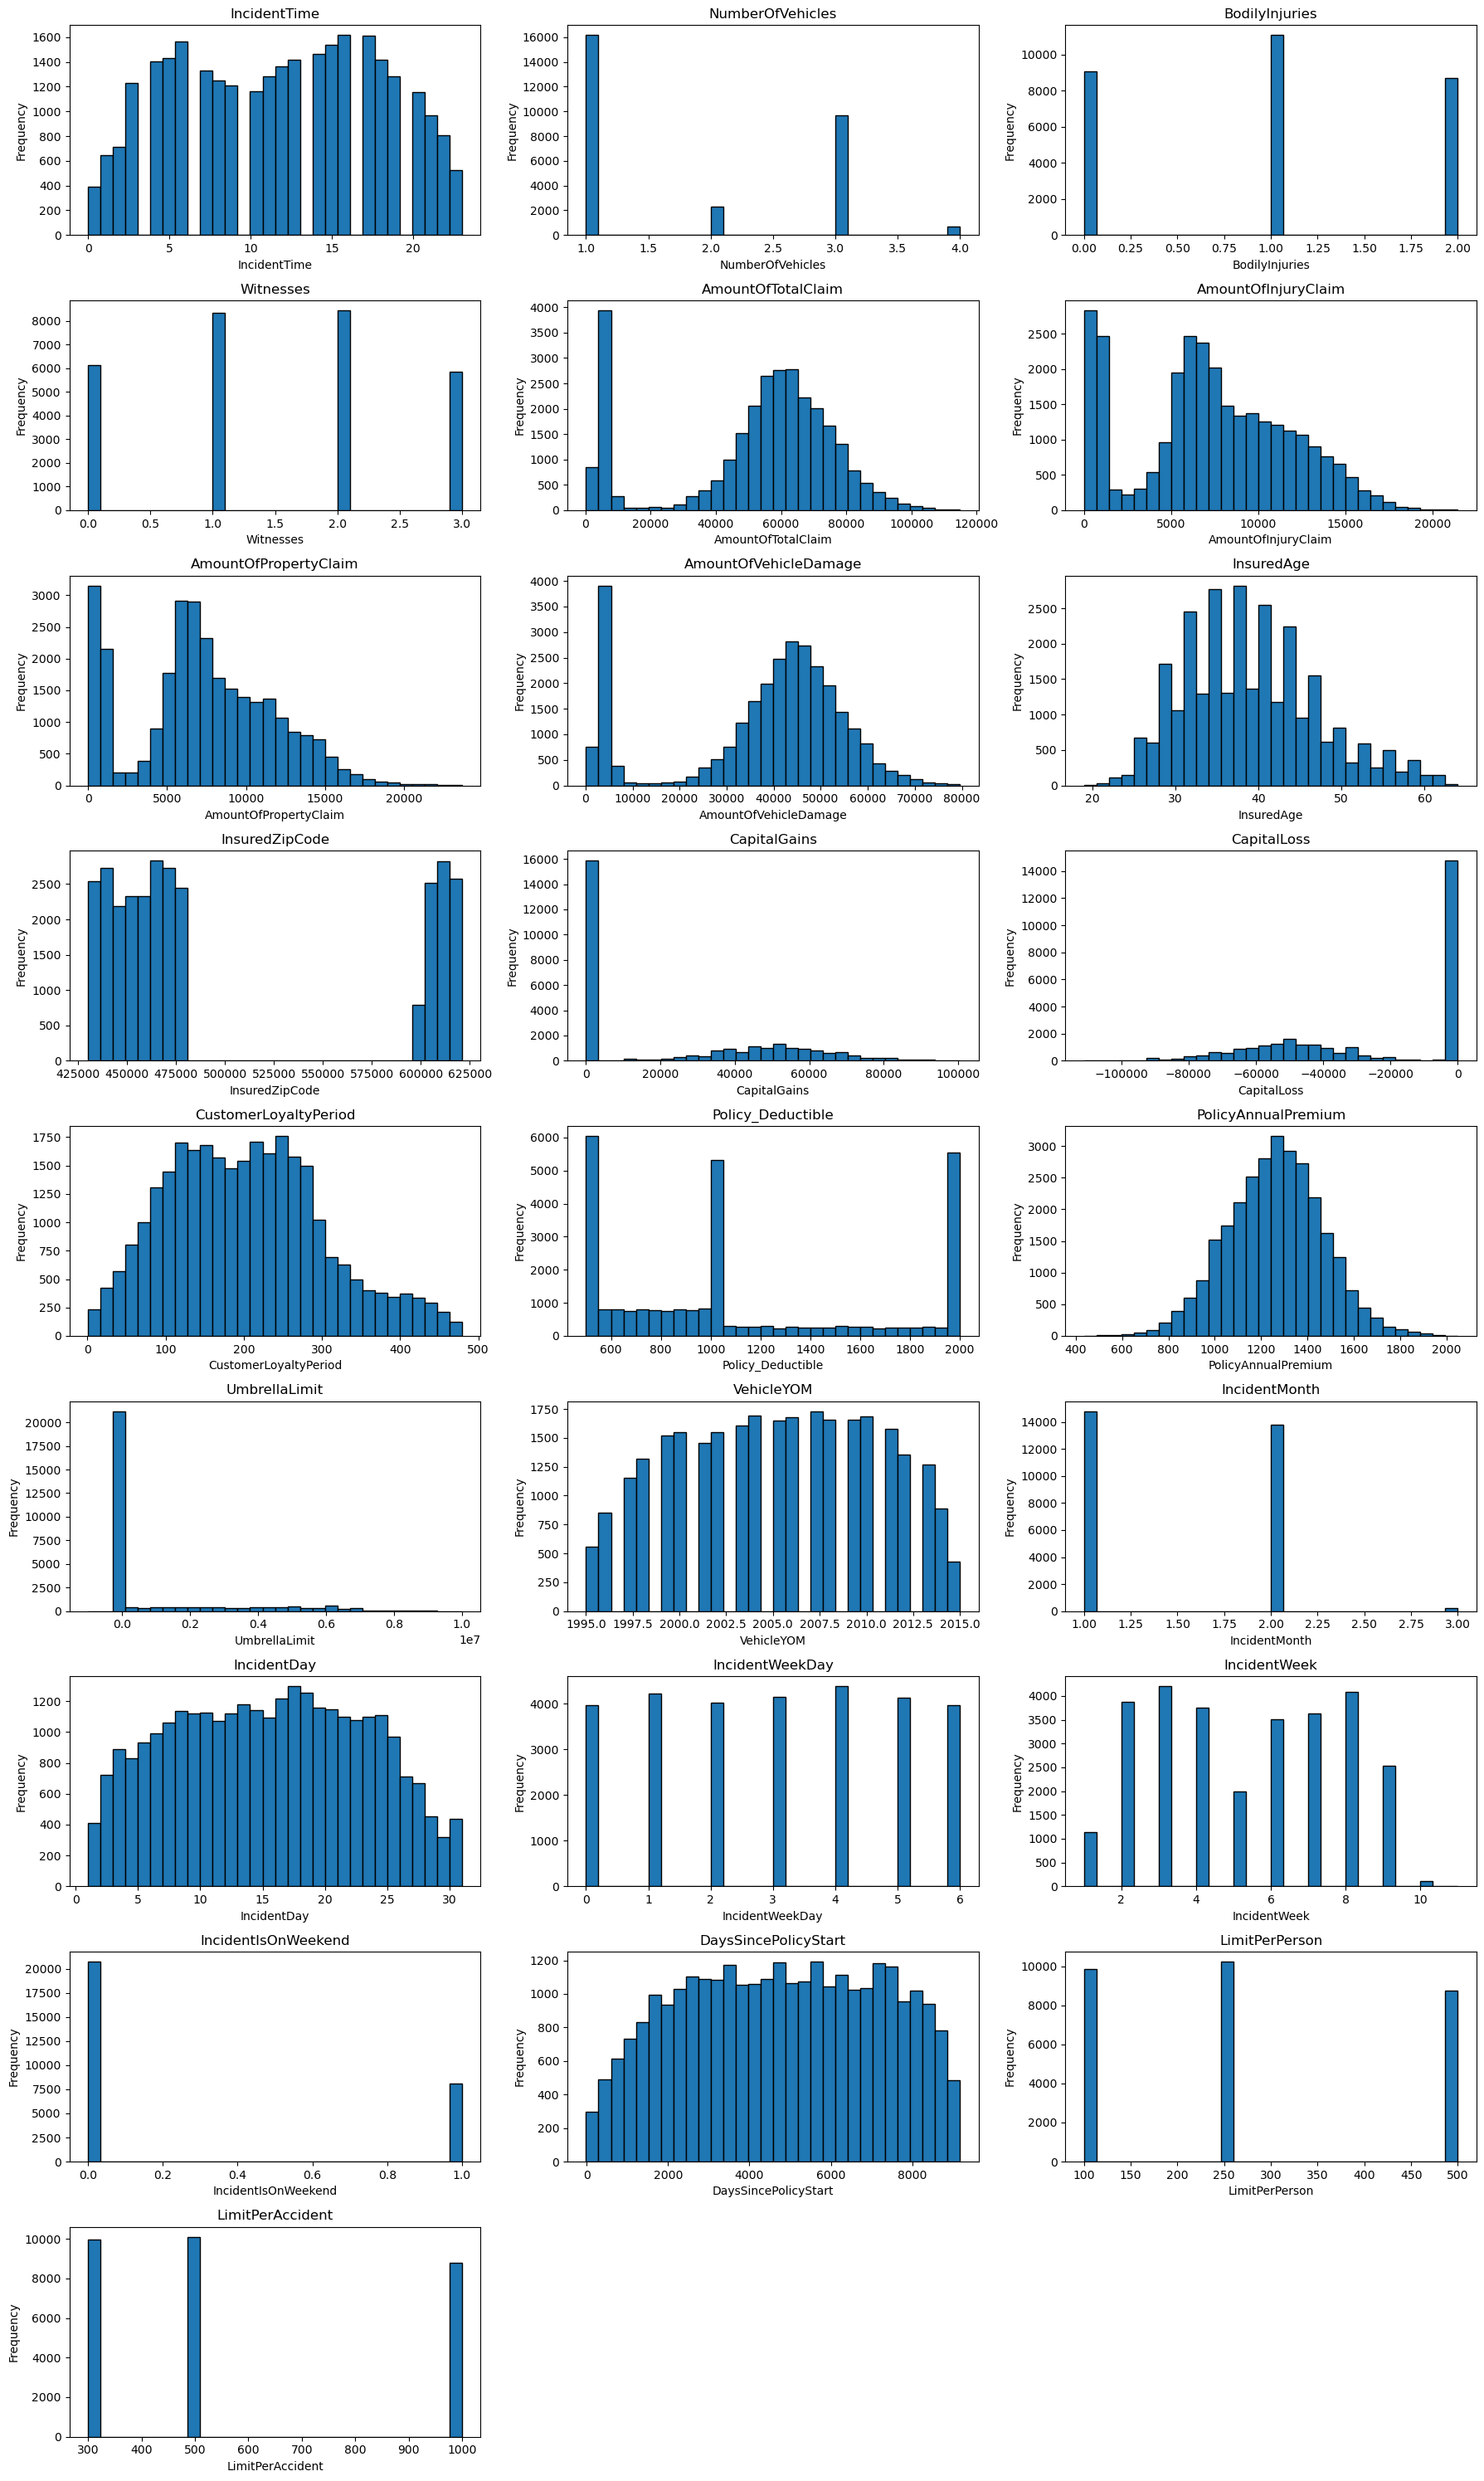

In [598]:

# Select numeric columns only
numeric_columns = merged_df.select_dtypes(include=['int64', 'float64', 'Int64', 'UInt32', 'int32']).columns

fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(18, 30))  # Adjust size as needed
axes = axes.flatten()

# Plot histogram for each numeric column
for i, col in enumerate(numeric_columns):
    axes[i].hist(merged_df[col].dropna(), bins=30, edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_ylabel("Frequency")
    axes[i].set_xlabel(col)

# Remove any extra empty plots (if less than 27)
for j in range(len(numeric_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



#### ⚙️ Feature Scaling Strategy

To ensure consistent model performance and interpretability, numeric features are scaled based on their nature using the following rules:

---


#### ✅ 1. High-Cardinality / Continuous Features → Use `StandardScaler`

These features have wide numeric ranges and many unique values. Standardization helps center and scale them.

| Feature                    | Unique Values |
|----------------------------|----------------|
| `InsurancePolicyNumber`    | 28836          |
| `PolicyAnnualPremium`      | 23852          |
| `AmountOfTotalClaim`       | 21976          |
| `AmountOfVehicleDamage`    | 20041          |
| `AmountOfInjuryClaim`      | 11958          |
| `AmountOfPropertyClaim`    | 11785          |
| `DaysSincePolicyStart`     | 7358           |
| `UmbrellaLimit`            | 7089           |
| `Policy_Deductible`        | 1496           |
| `InsuredZipCode`           | 995            |
| `CustomerLoyaltyPeriod`    | 479            |
| `CapitalLoss`              | 354            |
| `CapitalGains`             | 338            |


---

#### 🌗 2. Medium-Cardinality / Bounded Features → Use `MinMaxScaler`

These features are bounded and ordinal but not fully continuous. MinMax scaling preserves range and order.

| Feature              | Unique Values |
|----------------------|----------------|
| `IncidentDay`        | 31             |
| `IncidentTime`       | 25             |
| `VehicleYOM`         | 21             |
| `IncidentWeek`       | 11             |
| `InsuredAge`         | 46             |


---

#### 🚫 3. Low-Cardinality Integer Features (< 10 unique values) → Leave As-Is

Skip scaling for features that:
- Have **very few unique values**
- Are effectively discrete categories or count indicators


| Feature                 | Unique Values |
|-------------------------|----------------|
| `IncidentWeekDay`       | 7              |
| `Witnesses`             | 5              |
| `NumberOfVehicles`      | 4              |
| `IncidentMonth`         | 3              |
| `BodilyInjuries`        | 3              |
| `LimitPerPerson`        | 3              |
| `LimitPerAccident`      | 3              |
| `IncidentIsOnWeekend`   | 2              |



> These features can be optionally treated as categorical and one-hot encoded, depending on model sensitivity.

---
### 🧠 Summary of Scaling Strategy

- **StandardScaler** → For continuous, high-cardinality numeric features  
- **MinMaxScaler** → For bounded, ordinal-like features  
- **Leave As-Is** → For low-cardinality (≤10) features — possibly treat as categorical

This ensures optimal performance across different model types without misrepresenting the data.
---

This approach balances **model performance**, **interpretability**, and **data integrity** across preprocessing.



#### 🧼 Missing Value Handling Strategy

This section outlines the strategy used for imputing missing values across different types of features prior to modeling with Logistic Regression.

---

#### ✅ 1. High-Cardinality / Continuous Features → `StandardScaler`

These features have wide ranges and many unique values. They are typically numeric and continuous.

**Imputation Strategy**:  
- `SimpleImputer(strategy='mean')`

**Reason**:  
- The mean preserves the central tendency for normally distributed features.
- Compatible with standardization which centers and scales data.

**Columns**:
- `PolicyAnnualPremium`
- `AmountOfTotalClaim`
- `AmountOfVehicleDamage`
- `AmountOfInjuryClaim`
- `AmountOfPropertyClaim`
- `DaysSincePolicyStart`
- `UmbrellaLimit`
- `Policy_Deductible`
- `InsuredZipCode`
- `CustomerLoyaltyPeriod`
- `CapitalLoss`
- `CapitalGains`

---

#### ✅ 2. Bounded / Mid-Cardinality Features → `MinMaxScaler`

These are typically bounded or ordinal numerical features with moderate variability.

**Imputation Strategy**:  
- `SimpleImputer(strategy='median')`

**Reason**:  
- Median is robust to skewed distributions and outliers.
- MinMaxScaler is sensitive to outliers, so median ensures stable range.

**Columns**:
- `IncidentDay`
- `IncidentTime`
- `VehicleYOM`
- `IncidentWeek`
- `InsuredAge`

---

#### ✅ 3. Low-Cardinality / Count or Flag Features → Leave Unscaled

These are discrete, count-based, or binary features.

**Imputation Strategy**:  
- `SimpleImputer(strategy='most_frequent')`  


**Reason**:  
- These features often represent "presence" or "absence" of an event.
- Most frequent value is appropriate for small-range integer features.

**Columns**:
- `IncidentWeekDay`
- `Witnesses`
- `NumberOfVehicles`
- `IncidentMonth`
- `BodilyInjuries`
- `LimitPerPerson`
- `LimitPerAccident`
- `IncidentIsOnWeekend`

---

#### ✅ Categorical Columns (One-Hot Encoded)

Categorical features are handled separately using `OneHotEncoder`.

**Imputation Strategy**:  
- Imputation with `most_frequent` or `constant='missing'` can be optionally applied **before encoding**.

**Encoding Strategy**:  
- `OneHotEncoder(handle_unknown='ignore', sparse_output=False)`

---

## 🔁 Summary Table

| Feature Group                | Scaler         | Imputer Strategy             |
|-----------------------------|----------------|------------------------------|
| Continuous (high-cardinality) | StandardScaler | Mean                         |
| Bounded/ordinal              | MinMaxScaler   | Median                       |
| Counts, flags (low cardinality) | None         | Most Frequent / Constant(0)  |
| Categorical (object type)    | OneHotEncoder  | Most Frequent / Constant     |


#### Workflow
1. Split dataset ➜ training + testing
2. Fit encoder on training data
3. Transform both training and testing data using the encoder
4. Perform collinearity analysis (e.g., correlation or VIF) on training data
5. Drop collinear features in training set
6. Drop the same features in the test set (use the same column names)
7. Fit the model on training ➜ test on testing


### ✅ Model Selection Justification

For this classification task, I have selected **Logistic Regression** and **Random Forest** as the two modeling techniques.  
**Logistic Regression** was chosen for its simplicity, efficiency, and interpretability, especially in capturing linear relationships.  
**Random Forest** was selected to handle more complex, non-linear interactions and to leverage its robustness and feature importance capabilities.  
Together, these models provide a strong foundation for comparison — balancing interpretability with predictive power.


### Technique 1 - **Logistic Regrssion**

In [599]:

# 1. StandardScaler for high-cardinality / continuous features
standard_scale_cols = [
    'PolicyAnnualPremium', 'AmountOfTotalClaim', 'AmountOfVehicleDamage',
    'AmountOfInjuryClaim', 'AmountOfPropertyClaim', 'DaysSincePolicyStart',
    'UmbrellaLimit', 'Policy_Deductible', 'InsuredZipCode',
    'CustomerLoyaltyPeriod', 'CapitalLoss', 'CapitalGains'
]


# 2. MinMaxScaler for bounded or mid-cardinality features
minmax_scale_cols = [
    'IncidentDay', 'IncidentTime', 'VehicleYOM',
    'IncidentWeek', 'InsuredAge'
]

# 3. Leave these features unscaled (either categorical or simple counts)
leave_unchanged_cols = [
    'IncidentWeekDay', 'Witnesses', 'NumberOfVehicles',
    'IncidentMonth', 'BodilyInjuries',
    'LimitPerPerson', 'LimitPerAccident',
    'IncidentIsOnWeekend'
]

# 4. Leave these features unscaled (either categorical or simple counts)
onehot_encode_cols = [
    'InsuredGender',
    'InsuredEducationLevel',
    'InsuredOccupation',
    'InsuredHobbies',
    'InsurancePolicyState',
    'InsuredRelationship',
    'AuthoritiesContacted',
    'TypeOfIncident',
    'TypeOfCollission',
    'SeverityOfIncident',
    'IncidentState',
    'IncidentCity',
    'VehicleMake',
    'VehicleModel',
    'PropertyDamage',
    'PoliceReport',
]

target_col = ['ReportedFraud']

print('Total Columns ', len(merged_df.columns)) , print('Sum of All Columns' , len(standard_scale_cols) + len(minmax_scale_cols) + len(leave_unchanged_cols) +  len(onehot_encode_cols) + len(target_col))

# set(merged_df.columns) - set(onehot_encode_cols + minmax_scale_cols + onehot_encode_cols + target_col)

assigned_cols = set(
    standard_scale_cols +
    minmax_scale_cols +
    onehot_encode_cols +
    leave_unchanged_cols +
    ['ReportedFraud']  # target
)

unassigned_cols = assigned_cols - set(merged_df.columns) 
print("⚠️ Unassigned Columns:", unassigned_cols)




Total Columns  42
Sum of All Columns 42
⚠️ Unassigned Columns: set()


In [600]:
# Class to find which features are highly corelated and can be dropped i.e threshold > 0.9
class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9):
        self.threshold = threshold
        self.columns_to_drop_ = []

    def fit(self, X, y=None):
        numeric_df = X.select_dtypes(include=['number'])
        corr_matrix = numeric_df.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.columns_to_drop_ = [column for column in upper.columns if any(upper[column] > self.threshold)]
        return self

    def transform(self, X):
        return X.drop(columns=self.columns_to_drop_, errors='ignore')


## 🔒 Regularization Strategy in Logistic Regression

Regularization helps prevent overfitting by penalizing large coefficients in logistic regression. In this project, we apply L2 regularization (Ridge) by default.

### 📌 Regularization Type: L2 (Ridge)

- **Penalty**: `'l2'`
- **Solver**: `'liblinear'` (supports L1 and L2)
- **Strength**: `C=1.0` (default; smaller values mean stronger regularization)

### ✅ Why L2 Regularization?

- It **shrinks** all coefficients but **does not eliminate** any feature entirely.
- It is robust and works well with **correlated features**.
- Helps generalize better on unseen data by controlling model complexity.

In [601]:
print(merged_df['ReportedFraud'].value_counts())



ReportedFraud
N    21051
Y     7785
Name: count, dtype: int64


In [602]:


# STEP 1: Define target and features
X = merged_df.drop(columns=['ReportedFraud'])
y = merged_df['ReportedFraud'].map({'N': 0, 'Y': 1})

# STEP 2: Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Fit correlation filter on X_train
corr_filter = CorrelationFilter(threshold=0.9)
X_corr_filtered = corr_filter.fit_transform(X_train)

# Store which columns were dropped
columns_dropped = corr_filter.columns_to_drop_

print("Corelated Columns  Dropped:" , columns_dropped)

# Rebuild column lists by removing dropped ones
standard_scale_cols = [col for col in standard_scale_cols if col not in columns_dropped]
minmax_scale_cols = [col for col in minmax_scale_cols if col not in columns_dropped]
leave_unchanged_cols = [col for col in leave_unchanged_cols if col not in columns_dropped]
onehot_encode_cols = [col for col in onehot_encode_cols if col not in columns_dropped]


# Define  imputation
standard_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])

minmax_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', MinMaxScaler())
])

unchanged_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent'))  
])

# STEP 3: Define your column lists (manually or from previous logic)
# standard_scale_cols, minmax_scale_cols, onehot_encode_cols, leave_unchanged_cols

# STEP 4: Define preprocessor
# Combine in ColumnTransformer
preprocessor = ColumnTransformer([
    ('standard', standard_pipeline, standard_scale_cols),
    ('minmax', minmax_pipeline, minmax_scale_cols),
    ('unchanged', unchanged_pipeline, leave_unchanged_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), onehot_encode_cols)
], remainder='drop')

# STEP 5: Final pipeline including CorrelationFilter
pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(
        class_weight='balanced',
        penalty='l2',
        C=1.0,
        solver='liblinear',
        max_iter=1000
    ))
])

# STEP 6: Fit and Evaluate
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))


Corelated Columns  Dropped: ['AmountOfVehicleDamage', 'CustomerLoyaltyPeriod']
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      4211
           1       0.62      0.78      0.69      1557

    accuracy                           0.81      5768
   macro avg       0.77      0.80      0.78      5768
weighted avg       0.83      0.81      0.82      5768



### Learning & Precision-Recall Curve

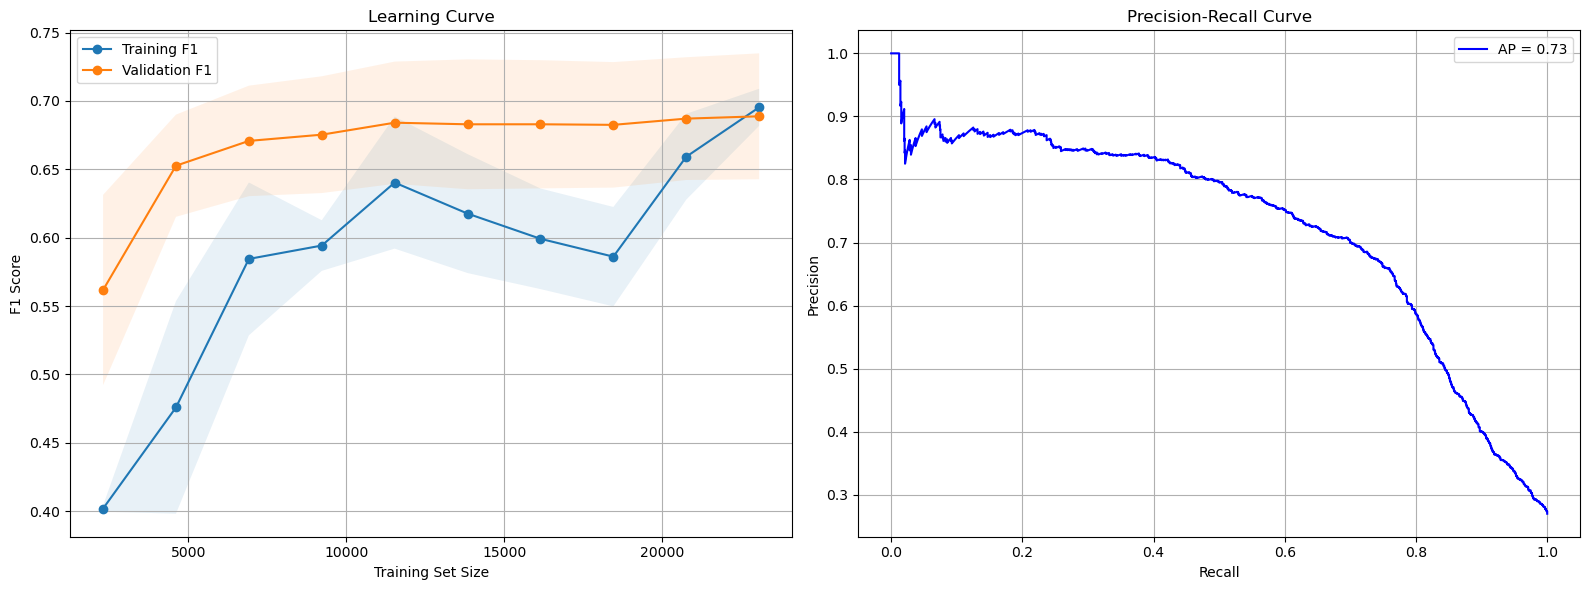

In [603]:

# ---- 1️⃣ Learning Curve ----
train_sizes, train_scores, val_scores = learning_curve(
    estimator=pipeline,
    X=X,
    y=y,  # Already 0/1
    cv=5,
    scoring='f1',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)

# ---- 2️⃣ Precision-Recall Curve ----
pipeline.fit(X_train, y_train)  # y_train is already 0/1
y_probs = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
ap_score = average_precision_score(y_test, y_probs)

# ---- 📊 Plot Both ----
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Learning Curve
axs[0].plot(train_sizes, train_mean, 'o-', label='Training F1')
axs[0].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
axs[0].plot(train_sizes, val_mean, 'o-', label='Validation F1')
axs[0].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
axs[0].set_title('Learning Curve')
axs[0].set_xlabel('Training Set Size')
axs[0].set_ylabel('F1 Score')
axs[0].legend()
axs[0].grid(True)

# Plot 2: Precision-Recall Curve
axs[1].plot(recall, precision, label=f'AP = {ap_score:.2f}', color='blue')
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision-Recall Curve')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


## 📊 Model Evaluation Summary

This section interprets the learning curve and precision-recall curve for the logistic regression model applied to fraud detection.

---

### 📘 1. Learning Curve Interpretation

#### 🔍 Observations:
- **Training F1 Score (blue)** starts low and steadily increases as more training data is used.
- **Validation F1 Score (orange)** starts higher and quickly plateaus around ~0.69.
- The gap between training and validation scores **narrows** as data increases.

#### ✅ Interpretation:
| Observation | Insight |
|-------------|---------|
| Training F1 improves with data | Model is learning meaningful patterns |
| Validation F1 stabilizes early | Model generalizes well after a moderate amount of data |
| Small gap between curves | Low variance and low bias (no overfitting or underfitting) |
| Final Validation F1 ≈ 0.69 | Reasonably strong for fraud detection |

#### 🧠 Conclusion:
- The model is **well-regularized** and does not overfit.
- Performance **scales with more data**, suggesting room for further improvement.
- Consider experimenting with more expressive models (e.g., Random Forest, XGBoost) or better features.

---

### 📙 2. Precision-Recall Curve Interpretation

#### 🔍 Observations:
- Precision starts near **1.0** when recall is very low — model is highly accurate when selective.
- As recall increases, precision **gradually decreases** — expected behavior in imbalanced classification.
- **Average Precision (AP) = 0.73**, indicating strong precision-recall trade-off.

#### ✅ Interpretation:
| Metric | Meaning |
|--------|---------|
| High precision at low recall | Model is highly confident in top predictions |
| Slow drop in precision | Maintains good accuracy as recall increases |
| Area under curve (AP = 0.73) | Strong performance in fraud detection scenario |

#### 🧠 Conclusion:
- The model is **effective at detecting frauds** while minimizing false positives.
- Depending on business needs, you can **adjust the threshold** to:
  - Increase recall (catch more frauds, accept more false positives)
  - Increase precision (fewer false alerts, possibly miss some frauds)

---

## ✅ Final Takeaways

| Aspect             | Status                                      |
|--------------------|---------------------------------------------|
| Bias/Variance       | Balanced — low overfitting and underfitting |
| Generalization      | Good performance on validation data         |
| PR Curve Quality    | High-quality fraud detection trade-off      |
| Recommendations     | Consider tuning threshold, trying ensemble models, or engineering domain features


### Logistic Regression with GridSearchCV and StraifiedKFold

In [604]:
# Define hyperparameter grid
param_grid = {
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [0.01, 0.1, 1, 10, 100]  # Lower = stronger regularization
}

# Define Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',  # or 'roc_auc', 'precision', etc.
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Fit the search
grid_search.fit(X, y)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/homebrew/Caskroom/miniconda/base/envs/.uol/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('standard',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer()),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         ['PolicyAnnualPremium',
                                                                          'AmountOfTotalClaim',
                                                                          'AmountOfInjuryClaim',
                                                                          'AmountOfPropertyClaim',
                                                                          'DaysSincePolicyStart',
                                                                          'Umbrell...
                                                                          'AuthoritiesContacted',
                                                                          'TypeOfIncident',
                                                                          'TypeOfCollission',
                                                                          'SeverityOfIncident',
                                                                          'IncidentState',
                                                                          'IncidentCity',
                                                                          'VehicleMake',
                                                                          'VehicleModel',
                                                                          'PropertyDamage',
                                                                          'PoliceReport'])])),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.01, 0.1, 1, 10, 100],
                         'clf__penalty': ['l1', 'l2']},
             scoring='f1', verbose=1)

In [605]:
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Use the best model
best_pipeline = grid_search.best_estimator_

Best Parameters: {'clf__C': 0.1, 'clf__penalty': 'l1'}
Best F1 Score: 0.6931069928889806


### Technique 1 - **RandomForest**

### Motivation for choosing the technique and schematic figure of the analysis process

### 🌲 Why Use Random Forest for Fraud Detection?

Random Forest is an ensemble method based on decision trees, and it's particularly well-suited for fraud detection due to the following reasons:

### ✅ Motivation

- **Handles Non-Linear Relationships**: Unlike Logistic Regression, Random Forest captures complex patterns and interactions between features.
- **Robust to Outliers & Imbalanced Data**: It performs well even when the data has extreme values or unbalanced classes.
- **Automatic Feature Selection**: It reduces the importance of irrelevant features and focuses on informative ones.
- **Low Tuning Overhead**: Works well with default parameters, but can be fine-tuned for better performance.
- **Feature Importance Insight**: Gives insights into which features contribute most to fraud predictions.

### 🧠 When to Prefer Over Logistic Regression
| Scenario                             | Random Forest Advantage          |
|--------------------------------------|----------------------------------|
| Nonlinear or complex feature spaces  | ✔ Handles it without manual feature engineering |
| Feature interactions                 | ✔ Captures them automatically   |
| Imbalanced datasets (like fraud)     | ✔ Robust with `class_weight`    |
| No assumption about data distribution| ✔ Unlike logistic regression     |





## 🔁 Schematic Flow of the Analysis Process

```mermaid
graph TD
    A[Raw Insurance Dataset] --> B[Preprocessing & Cleaning]
    B --> C[Correlation Filter]
    C --> D[Feature Engineering]
    D --> E[Train-Test Split]
    E --> F[ColumnTransformer]
    F --> G[Random Forest Model]
    G --> H[Cross-Validation with Stratified K-Fold]
    H --> I[Evaluation (F1, PR Curve, Feature Importance)]
    I --> J[Model Interpretation & Threshold Tuning]

  

### ⚙️ Random Forest Hyperparameter Settings (with Rationale)

| Hyperparameter      | Typical Value(s)   | Rationale                                                                 |
|---------------------|--------------------|---------------------------------------------------------------------------|
| `n_estimators`      | `100` to `300`     | Number of trees in the forest; more trees improve stability but increase training time. |
| `max_depth`         | `None`, `10`, `20` | Controls tree depth; prevents overfitting. `None` allows full growth.     |
| `min_samples_split` | `2`, `5`, `10`     | Minimum samples needed to split a node; higher value = more regularization. |
| `min_samples_leaf`  | `1`, `2`, `4`      | Minimum samples per leaf; prevents overly deep trees.                     |
| `max_features`      | `'sqrt'`, `'log2'` | Feature sampling per split. `'sqrt'` is good default for classification.  |
| `class_weight`      | `'balanced'`       | Helps address fraud vs non-fraud imbalance.                              |
| `random_state`      | `42` (fixed)       | Ensures reproducibility of results.                                      |

### 🧠 Why These Matter in Fraud Detection:

- **Imbalanced data** → `class_weight='balanced'` ensures frauds are not ignored.
- **Many features** → `max_features='sqrt'` reduces overfitting.
- **Noisy data** → `min_samples_leaf=2` or `5` prevents trees from memorizing noise.


In [608]:


# STEP 1: Define target and features
X = merged_df.drop(columns=['ReportedFraud'])
y = merged_df['ReportedFraud'].map({'N': 0, 'Y': 1})

# STEP 2: Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Fit correlation filter on X_train
corr_filter = CorrelationFilter(threshold=0.9)
X_corr_filtered = corr_filter.fit_transform(X_train)

# Store which columns were dropped
columns_dropped = corr_filter.columns_to_drop_

print("Corelated Columns  Dropped:" , columns_dropped)

# Rebuild column lists by removing dropped ones
standard_scale_cols = [col for col in standard_scale_cols if col not in columns_dropped]
minmax_scale_cols = [col for col in minmax_scale_cols if col not in columns_dropped]
leave_unchanged_cols = [col for col in leave_unchanged_cols if col not in columns_dropped]
onehot_encode_cols = [col for col in onehot_encode_cols if col not in columns_dropped]


# Define  imputation
standard_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])

minmax_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', MinMaxScaler())
])

unchanged_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent'))  
])

# STEP 3: Define your column lists (manually or from previous logic)
# standard_scale_cols, minmax_scale_cols, onehot_encode_cols, leave_unchanged_cols

# STEP 4: Define preprocessor
# Combine in ColumnTransformer
preprocessor = ColumnTransformer([
    ('standard', standard_pipeline, standard_scale_cols),
    ('minmax', minmax_pipeline, minmax_scale_cols),
    ('unchanged', unchanged_pipeline, leave_unchanged_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), onehot_encode_cols)
], remainder='drop')

# STEP 5: Final pipeline including CorrelationFilter
pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_leaf=2,
        max_features='sqrt',
        class_weight='balanced',
        random_state=42
    ))
])

# STEP 6: Fit and Evaluate
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))


Corelated Columns  Dropped: ['AmountOfVehicleDamage', 'CustomerLoyaltyPeriod']
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      4211
           1       0.92      0.79      0.85      1557

    accuracy                           0.92      5768
   macro avg       0.92      0.88      0.90      5768
weighted avg       0.92      0.92      0.92      5768



### Learning and Precision Recall Curve

/opt/homebrew/Caskroom/miniconda/base/envs/.uol/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


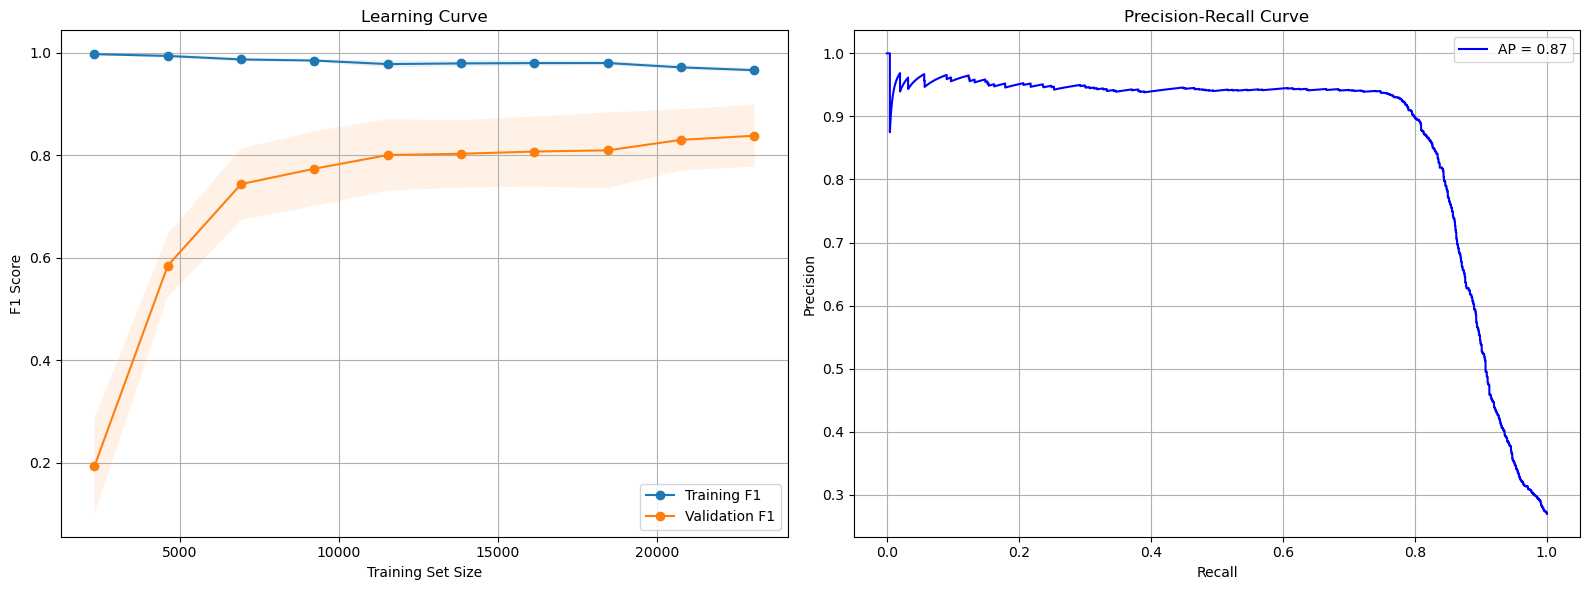

In [609]:

# ---- 1️⃣ Learning Curve ----
train_sizes, train_scores, val_scores = learning_curve(
    estimator=pipeline,
    X=X,
    y=y,  # Already 0/1
    cv=5,
    scoring='f1',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)

# ---- 2️⃣ Precision-Recall Curve ----
pipeline.fit(X_train, y_train)  # y_train is already 0/1
y_probs = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
ap_score = average_precision_score(y_test, y_probs)

# ---- 📊 Plot Both ----
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Learning Curve
axs[0].plot(train_sizes, train_mean, 'o-', label='Training F1')
axs[0].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
axs[0].plot(train_sizes, val_mean, 'o-', label='Validation F1')
axs[0].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
axs[0].set_title('Learning Curve')
axs[0].set_xlabel('Training Set Size')
axs[0].set_ylabel('F1 Score')
axs[0].legend()
axs[0].grid(True)

# Plot 2: Precision-Recall Curve
axs[1].plot(recall, precision, label=f'AP = {ap_score:.2f}', color='blue')
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision-Recall Curve')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


### Add GridSearchCV

In [612]:
# Define hyperparameter grid
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
    'clf__max_features': ['sqrt', 'log2']
}

# Define Stratified K-Fold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',  # or 'roc_auc', 'precision', etc.
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Fit the search
grid_search.fit(X, y)


Fitting 10 folds for each of 48 candidates, totalling 480 fits


/opt/homebrew/Caskroom/miniconda/base/envs/.uol/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('standard',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer()),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         ['PolicyAnnualPremium',
                                                                          'AmountOfTotalClaim',
                                                                          'AmountOfInjuryClaim',
                                                                          'AmountOfPropertyClaim',
                                                                          'DaysSincePolicyStart',
                                                                          'Umbrel...
                                                                          'VehicleMake',
                                                                          'VehicleModel',
                                                                          'PropertyDamage',
                                                                          'PoliceReport'])])),
                                       ('clf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               min_samples_leaf=2,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [None, 10, 20],
                         'clf__max_features': ['sqrt', 'log2'],
                         'clf__min_samples_leaf': [1, 2],
                         'clf__min_samples_split': [2, 5],
                         'clf__n_estimators': [100, 200]},
             scoring='f1', verbose=1)

In [618]:
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)


# Get the full best pipeline (preprocessing + model)
best_pipeline = grid_search.best_estimator_


# Make predictions
y_train_pred = best_pipeline.predict(X_train)
y_test_pred = best_pipeline.predict(X_test)

# Evaluate performance on training set
print("🔍 Training Set Performance")
print(classification_report(y_train, y_train_pred))

# Evaluate performance on test set
print("🔍 Test Set Performance")
print(classification_report(y_test, y_test_pred))

# Optional: Print compact comparison
print("📊 Accuracy Comparison")
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Test Accuracy:  {accuracy_score(y_test, y_test_pred):.4f}")

print("📊 F1 Score Comparison")
print(f"Train F1 Score: {f1_score(y_train, y_train_pred):.4f}")
print(f"Test F1 Score:  {f1_score(y_test, y_test_pred):.4f}")


Best Parameters: {'clf__max_depth': None, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Best F1 Score: 0.8564744958608415
🔍 Training Set Performance
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     16840
           1       0.96      0.95      0.95      6228

    accuracy                           0.97     23068
   macro avg       0.97      0.97      0.97     23068
weighted avg       0.97      0.97      0.97     23068

🔍 Test Set Performance
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      4211
           1       0.92      0.80      0.85      1557

    accuracy                           0.93      5768
   macro avg       0.92      0.88      0.90      5768
weighted avg       0.93      0.93      0.92      5768

📊 Accuracy Comparison
Train Accuracy: 0.9749
Test Accuracy:  0.9258
📊 F1 Score Comparison
Train F1 Score: 0.

### Learning Curve

/var/folders/2q/4h8qwwsx6t5446pyq1l03mjh0000gn/T/ipykernel_92294/876304462.py:33: UserWarning: Glyph 128218 (\N{BOOKS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/.uol/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128218 (\N{BOOKS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


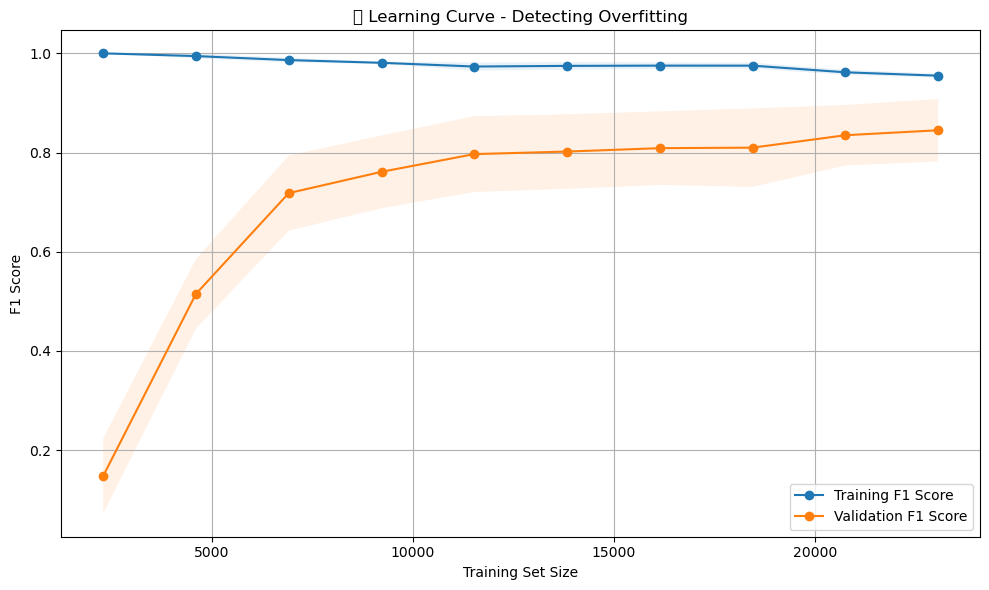

In [619]:
train_sizes, train_scores, val_scores = learning_curve(
    best_pipeline,
    X, y,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

# Mean and std deviation of scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training F1 Score')
plt.plot(train_sizes, val_scores_mean, 'o-', label='Validation F1 Score')
plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1)
plt.fill_between(train_sizes,
                 val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1)

plt.title("📚 Learning Curve - Detecting Overfitting")
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()



### 📊 Learning Curve Analysis – Random Forest

The learning curve below shows F1 scores for both the training and validation sets as the training size increases.


---

### 🔍 Observations

- **Training F1 Score (blue line)** remains near **1.0** across all training sizes.
- **Validation F1 Score (orange line)** starts low (~0.15), then steadily improves and **plateaus around 0.85**.
- There is a **consistent gap** between training and validation scores.

---

### ⚠️ Interpretation

| Observation                              | Interpretation                      |
|------------------------------------------|--------------------------------------|
| Training F1 near 1.0                     | Model is likely **overfitting** (memorizing training data) |
| Validation F1 improves with more data    | Model is learning, but not generalizing fully |
| Persistent gap between curves            | Classic sign of **overfitting** — model complexity may be too high |

---

### 🧠 Conclusion

> **The Random Forest model is overfitting.**  
It performs very well on the training set but does not generalize equally well to unseen data, as indicated by the validation F1 score plateau and the gap between the two curves.

---

## 🛠️ How to Reduce Overfitting

| Strategy                        | What to Change in the Model |
|---------------------------------|-----------------------------|
| Limit tree depth                | Use `max_depth=10` or `15` |
| Increase minimum samples per leaf | Use `min_samples_leaf=3` or `5` |
| Reduce features per split       | Try `max_features='log2'` |
| Reduce tree count               | Use `n_estimators=50–100` instead of very large values |
| Try less greedy trees           | Set `bootstrap=False` or try `ExtraTreesClassifier` |
| Add feature selection           | Remove redundant/noisy features before training |

---



In [620]:
# Define hyperparameter grid to avoid overfitting
param_grid = {
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [10, 15],
    'clf__min_samples_split': [2, 5,10],
    'clf__min_samples_leaf': [3, 5],
    'clf__max_features': ['log2'],
    'clf__class_weight': ['balanced']
}

# Define Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',  # or 'roc_auc', 'precision', etc.
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Fit the search
grid_search.fit(X, y)

print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)


# Get the full best pipeline (preprocessing + model)
best_pipeline = grid_search.best_estimator_


# Make predictions
y_train_pred = best_pipeline.predict(X_train)
y_test_pred = best_pipeline.predict(X_test)

# Evaluate performance on training set
print("🔍 Training Set Performance")
print(classification_report(y_train, y_train_pred))

# Evaluate performance on test set
print("🔍 Test Set Performance")
print(classification_report(y_test, y_test_pred))

# Optional: Print compact comparison
print("📊 Accuracy Comparison")
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Test Accuracy:  {accuracy_score(y_test, y_test_pred):.4f}")

print("📊 F1 Score Comparison")
print(f"Train F1 Score: {f1_score(y_train, y_train_pred):.4f}")
print(f"Test F1 Score:  {f1_score(y_test, y_test_pred):.4f}")

Fitting 10 folds for each of 24 candidates, totalling 240 fits
Best Parameters: {'clf__class_weight': 'balanced', 'clf__max_depth': 15, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 2, 'clf__n_estimators': 50}
Best F1 Score: 0.789614632370746
🔍 Training Set Performance
              precision    recall  f1-score   support

           0       0.95      0.94      0.94     16840
           1       0.84      0.86      0.85      6228

    accuracy                           0.92     23068
   macro avg       0.90      0.90      0.90     23068
weighted avg       0.92      0.92      0.92     23068

🔍 Test Set Performance
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      4211
           1       0.83      0.86      0.85      1557

    accuracy                           0.92      5768
   macro avg       0.89      0.90      0.89      5768
weighted avg       0.92      0.92      0.92      5768

📊 Accuracy Compa

### Learning Curve after making changes for Overfitting 

/var/folders/2q/4h8qwwsx6t5446pyq1l03mjh0000gn/T/ipykernel_92294/876304462.py:33: UserWarning: Glyph 128218 (\N{BOOKS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/.uol/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128218 (\N{BOOKS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


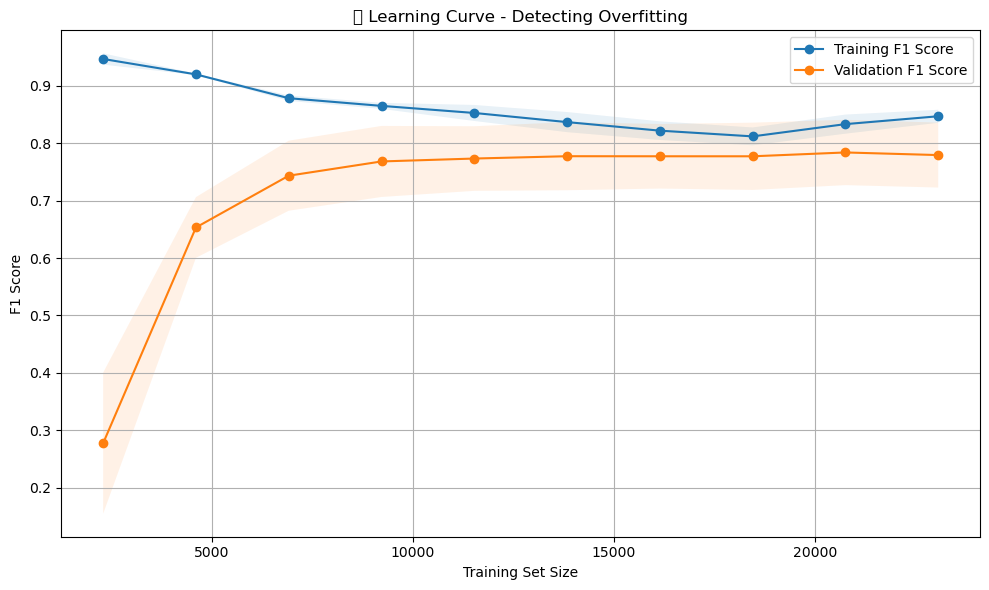

In [621]:
train_sizes, train_scores, val_scores = learning_curve(
    best_pipeline,
    X, y,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

# Mean and std deviation of scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training F1 Score')
plt.plot(train_sizes, val_scores_mean, 'o-', label='Validation F1 Score')
plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1)
plt.fill_between(train_sizes,
                 val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1)

plt.title("📚 Learning Curve - Detecting Overfitting")
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/2q/4h8qwwsx6t5446pyq1l03mjh0000gn/T/ipykernel_92294/962067939.py:66: UserWarning: Glyph 128218 (\N{BOOKS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2q/4h8qwwsx6t5446pyq1l03mjh0000gn/T/ipykernel_92294/962067939.py:66: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2q/4h8qwwsx6t5446pyq1l03mjh0000gn/T/ipykernel_92294/962067939.py:66: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/homebrew/Caskroom/miniconda/base/envs/.uol/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128218 (\N{BOOKS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniconda/base/envs/.uol/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(byt

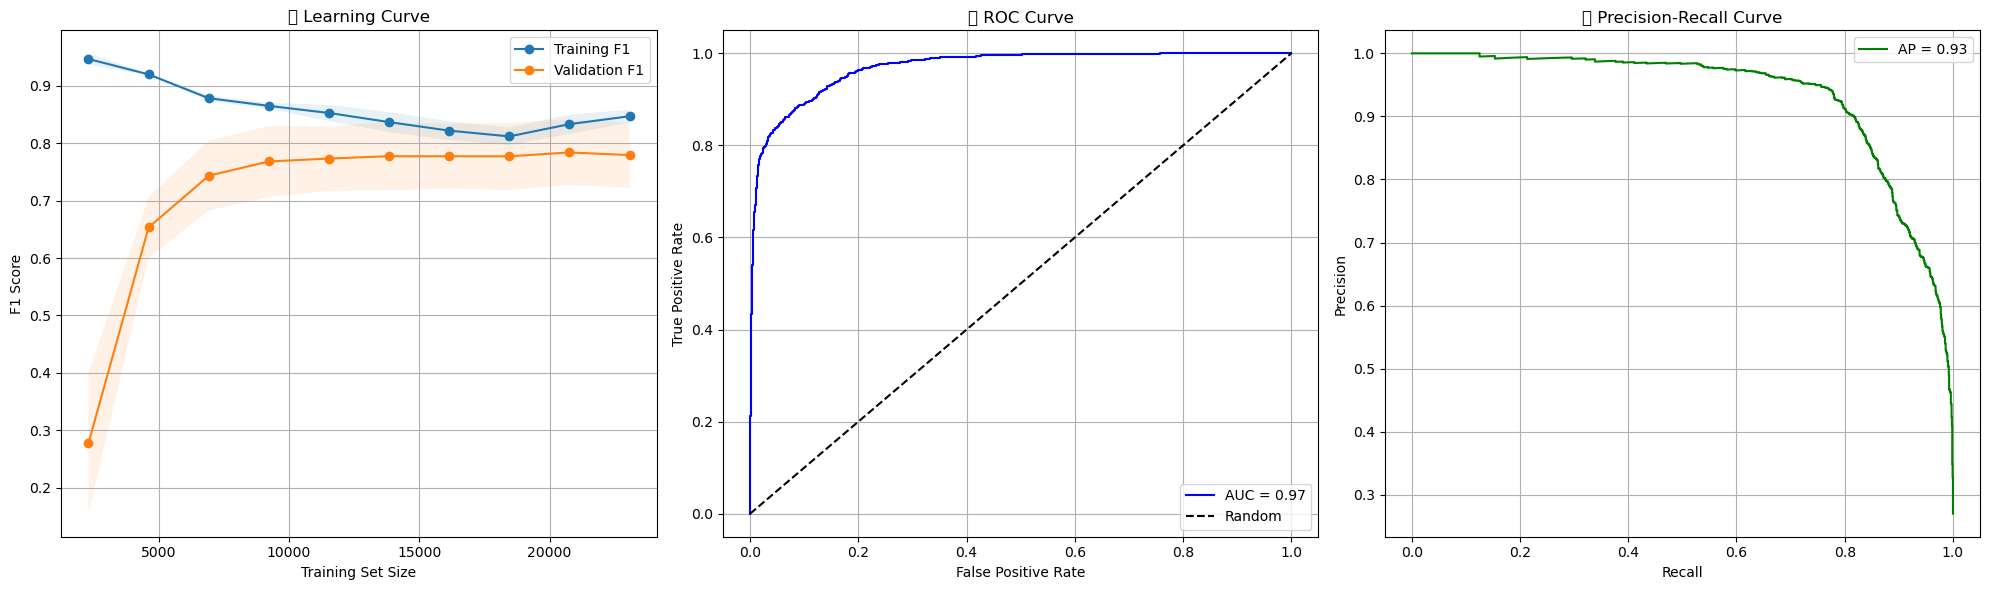

In [626]:


# Get predicted probabilities
y_scores = best_pipeline.predict_proba(X_test)[:, 1]

# ---- ROC curve values ----
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

# ---- Precision-recall values ----
precision, recall, _ = precision_recall_curve(y_test, y_scores)
avg_precision = average_precision_score(y_test, y_scores)

# ---- Learning curve values ----
train_sizes, train_scores, val_scores = learning_curve(
    best_pipeline,
    X,
    y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1',
    n_jobs=-1
)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)

# ---- Plotting ----
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Learning Curve
axs[0].plot(train_sizes, train_mean, 'o-', label='Training F1')
axs[0].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
axs[0].plot(train_sizes, val_mean, 'o-', label='Validation F1')
axs[0].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
axs[0].set_title('📚 Learning Curve')
axs[0].set_xlabel('Training Set Size')
axs[0].set_ylabel('F1 Score')
axs[0].legend()
axs[0].grid(True)

# ROC Curve
axs[1].plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='blue')
axs[1].plot([0, 1], [0, 1], 'k--', label="Random")
axs[1].set_title('📈 ROC Curve')
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].legend()
axs[1].grid(True)

# Precision-Recall Curve
axs[2].plot(recall, precision, label=f'AP = {avg_precision:.2f}', color='green')
axs[2].set_title('📊 Precision-Recall Curve')
axs[2].set_xlabel('Recall')
axs[2].set_ylabel('Precision')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


## 4. Technique 1
**Create a new subheading for each stage that you do from the following items. Enter your code in the cells below the subheading.**

- Motivation for choosing the technique and schematic figure of the analysis process (100-200 words)
- Setting hyperparameters (rationale)
- Optimising the hyperparameters appropriately
- Performance metrics for training set
- Other items necessary for the technique
- Deal with class imbalance, if necessary, if not done above

### 4.1 Motivation for choosing the technique and schematic figure of the analysis process

### Setting hyperparameters (rationale)

## 5. Technique 2
**Create a new subheading for each stage that you do from the following items. Enter your code in the cells below the subheading.**

- Motivation for choosing the technique and schematic figure of the analysis process (100-200 words)
- Setting hyperparameters (rationale)
- Optimising the hyperparameters appropriately
- Performance metrics for training set
- Other items necessary for the technique
- Deal with class imbalance, if necessary, if not done above

### 5.1 Motivation for choosing the technique and schematic figure of the analysis process

### Setting hyperparameters (rationale)

## 6. Comparison of metrics performance for testing

**Create a new subheading for each stage that you do from the following items. Enter your code in the cells below the subheading.**

- Use of nested cross-validation for both techniques to deal with overfitting model selection and model comparison
- Use appropriate metrics for the testing set
- Use an appropriate model selection visualisation curve (ROC, PR, etc.) that is suitable for the problem at hand
- Checking for overfitting

## 7. Final recommendation of the best model

**Create a new subheading for each item you discuss from the following items.**

- Technical perspective- overfitting discussion, complexity and efficiency
- Business perspective- results interpretation, relevance and balance with a technical perspective

## 8. Conclusion

**Create a new subheading for each item you discuss from the following items.**

- What has been successfully accomplished and what has not
- Reflect back on the analysis and see what you could have done differently if you were to do the project again
- Add a wish list of future work that you would do to take the project forward
